In [1]:
import importlib
import volpy_func_lib as vp
import load_clean_lib
import table_lib
import vol_strat_lib as vs
import option_returns as orpy
from global_settings import *
import pandas as pd
import numpy as np

importlib.reload(vp)
importlib.reload(load_clean_lib)
importlib.reload(table_lib)
importlib.reload(vs)
importlib.reload(orpy)

c:\Users\axell\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


<module 'option_returns' from 'c:\\Users\\axell\\Desktop\\CBS\\master\\volpy\\option_returns.py'>

### import orpy

In [114]:
# df_orpy = pd.read_csv(r"C:\Users\axell\Desktop\CBS\data\OptionMetrics\volpy data output\OEX_constituents_short\t_df_orpy.csv")
# df_orpy["date"] = pd.to_datetime(df_orpy["date"])

sum_df = pd.read_csv(r"C:\Users\axell\Desktop\CBS\data\OptionMetrics\volpy data output\OEX_constituents_short2\t_summary_dly.csv")
sum_df["date"] = pd.to_datetime(sum_df["date"])
sum_df[f"return_next"] = sum_df[f"return"].shift(-1)

### import constituents with manual mapping

In [115]:
oex_constituents = pd.read_excel(r"C:\Users\axell\Desktop\CBS\data\constituents.xlsx", sheet_name="OEXQ")
oex_constituents.columns = oex_constituents.columns.map(str)
oex_constituents_cleaned = oex_constituents.loc[:, ~oex_constituents.columns.str.contains("Unnamed")]
oex_constituents_fixed = oex_constituents_cleaned.iloc[1:].copy()

df_long = oex_constituents_fixed.melt(var_name="date", value_name="ticker")
df_long["date"] = pd.to_datetime(df_long["date"])
df_long = df_long.dropna(subset=["ticker"])
df_long["ticker"] = df_long["ticker"].astype(str).str.split(" ").str[0].str.strip()
df_long = df_long[df_long["ticker"] != ""]
oex_constituents_long = df_long

rename_map = {
    "0203524D": "NSM",
    "NRTLQ": "NT",
    "MTLQQ": "GM",
    "LEHMQ": "LEH",
    "NAN": "NQN",
    "RSHCQ": "RSH",
    "987200Q": "MAY",
    "748957Q": "PNU",
    "653707Q": "T",
    "605555Q": "S",
    "3621240Q": "ONE",
    "3605818Q": "HCA",
    "3346Q": "UBAN",
    "2968900Q": "IHRT",
    "2258717D": "EMC",
    "GBLXQ": "GBLX",
    "ENRNQ": "ENE",
    "EKDKQ": "KODK",
    "DALRQ": "DAL",
    "RTN/B": "RTNB",
    "1996074D": "EP",
    "3393199Q": "BUD",
    "1683997D": "DELL",
    "0848680D": "FYBR",
    "1255173D": "WB",
    "2071296D": "NYX",
    "1856613D": "MON",
    "BRK/B": "BRK",
    "9903115D": "CLB",
    "1028411Q": "G",
    "1697067D": "DOW",
    "1715651D": "DD"
}

# Omdøb tickers i din DataFrame
oex_constituents_long["ticker"] = oex_constituents_long["ticker"].replace(rename_map)

### get all crisp data

In [116]:
import pandas as pd

# Sæt filsti
file_path = r"C:\Users\axell\Desktop\CBS\data\crisp_data5.csv"

# Definér de relevante tickers på forhånd
relevant_tickers = set(oex_constituents_long["ticker"].unique())

# Opret tom liste til chunks
filtered_chunks = []

# Indlæs CSV i chunks
chunk_size = 500_000  # du kan justere denne størrelse efter behov

for chunk in pd.read_csv(file_path, chunksize=chunk_size, low_memory=False):
    # Filtrér på relevante tickere
    chunk_filtered = chunk[chunk["TICKER"].isin(relevant_tickers)].copy()
    filtered_chunks.append(chunk_filtered)

# Saml alle filtrerede chunks
crsp_data = pd.concat(filtered_chunks, ignore_index=True)

# Done
print(f"CRSP-data form: {crsp_data.shape}")


CRSP-data form: (1089089, 8)


### mapping constituents to traiding days from crisp and calculate market cap and return

In [185]:
import pandas as pd # V3
import numpy as np

# Sørg for datetime-format
crsp_data["date"] = pd.to_datetime(crsp_data["date"])
crsp_data["NEXTDT"] = pd.to_datetime(crsp_data["NEXTDT"])  # NY!
oex_constituents_long["date"] = pd.to_datetime(oex_constituents_long["date"])

# Handelsdage fra CRSP
trading_days = crsp_data[["date"]].drop_duplicates().sort_values("date").reset_index(drop=True)

# Unikke skæringsdatoer i constituents
constituent_dates = oex_constituents_long["date"].sort_values().unique()

# Match hver handelsdag med seneste gældende constituent-dag
date_lookup = []
for trading_day in trading_days["date"]:
    valid_dates = constituent_dates[constituent_dates <= trading_day]
    if len(valid_dates) == 0:
        continue
    last_valid_date = valid_dates[-1]
    date_lookup.append((trading_day, last_valid_date))

lookup_df = pd.DataFrame(date_lookup, columns=["date", "constituent_date"])

# Tilføj tickere fra constituents
expanded = lookup_df.merge(
    oex_constituents_long,
    left_on="constituent_date",
    right_on="date",
    suffixes=("_trading", "_constituent")
)

# Kun relevante kolonner
expanded_constituents = expanded[["date_trading", "ticker"]]
expanded_constituents = expanded_constituents.rename(columns={"date_trading": "date"}).sort_values(["date", "ticker"]).reset_index(drop=True)

# -------------------------------------
# Håndtér CRSP-afkast og DLRET korrekt
# -------------------------------------

# Sørg for numeriske kolonner
crsp_data["RET"] = pd.to_numeric(crsp_data["RET"], errors="coerce")
crsp_data["DLRET"] = pd.to_numeric(crsp_data["DLRET"], errors="coerce")

# Ugyldige return-koder
invalid_ret_codes = [-66.0, -77.0, -88.0, -99.0]
invalid_dlret_codes = [-55.0, -66.0, -88.0, -99.0]

# Sæt til NaN hvor ugyldigt
crsp_data.loc[crsp_data["RET"].isin(invalid_ret_codes), "RET"] = np.nan
crsp_data.loc[crsp_data["DLRET"].isin(invalid_dlret_codes), "DLRET"] = np.nan

# Delisting returns indsættes med NEXTDT som dato
dlret_df = crsp_data[["NEXTDT", "TICKER", "DLRET"]].dropna().rename(
    columns={"NEXTDT": "date", "TICKER": "ticker"}
)

# Merge expanded_constituents med RET (almindelige returns)
merged = expanded_constituents.merge(
    crsp_data[["date", "TICKER", "PRC", "SHROUT", "RET"]],
    left_on=["date", "ticker"],
    right_on=["date", "TICKER"],
    how="left"
)

# Merge delisting returns (DLRET) på NEXTDT
merged = merged.merge(
    dlret_df,
    on=["date", "ticker"],
    how="left"
)

# Beregn market cap
merged["market_cap"] = merged["PRC"].abs() * merged["SHROUT"]

# Kombinér return og DLRET: (1 + RET)*(1 + DLRET) - 1
merged["RET_combined"] = (1 + merged["RET"]) * (1 + merged["DLRET"].fillna(0)) - 1

# Fjern manglende returns og market cap
merged = merged.dropna(subset=["RET_combined", "market_cap"])
merged = merged.drop_duplicates(subset=["date", "ticker"])

# Beregn vægte og shift dem én dag bagud per ticker
merged["total_mc"] = merged.groupby("date")["market_cap"].transform("sum")
merged["weight"] = merged["market_cap"] / merged["total_mc"]
merged["weight"] = merged.groupby("ticker")["weight"].shift(1)

# Endelig portefølje-DataFrame
final_df = merged[["date", "ticker", "weight", "RET_combined"]].rename(columns={"RET_combined": "return"})
final_df = final_df.dropna(subset=["weight", "return"])


### number of constituents with data over time 

Mindste antal aktiver på en dag: 83


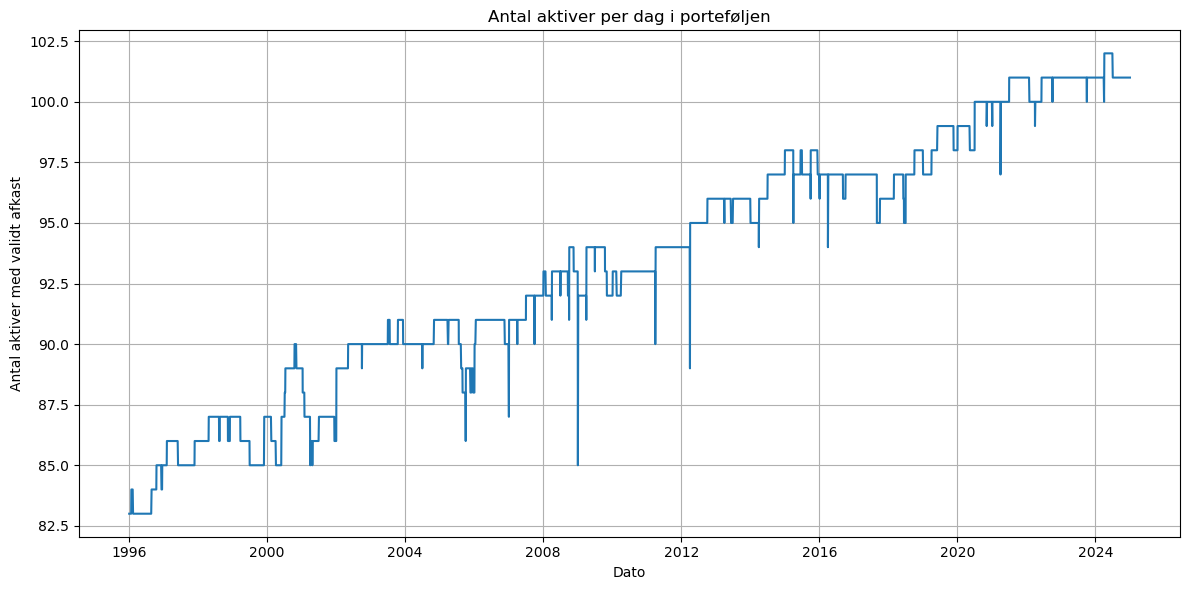

In [118]:
import matplotlib.pyplot as plt

# Tæl antal aktiver (ikke-NaN returns) per dag
assets_per_day = final_df.groupby("date")["return"].count()

# Udskriv mindste antal aktiver
print(f"Mindste antal aktiver på en dag: {assets_per_day.min()}")

# Plot antal aktiver over tid
plt.figure(figsize=(12,6))
plt.plot(assets_per_day.index, assets_per_day.values)
plt.xlabel("Dato")
plt.ylabel("Antal aktiver med validt afkast")
plt.title("Antal aktiver per dag i porteføljen")
plt.grid(True)
plt.tight_layout()
plt.show()


### calculate index returns

In [151]:
# Beregn vægtet afkast per dag
temp = final_df.copy()
temp["weighted_return"] = temp["weight"] * temp["return"]

# Summer vægtet afkast per dag → replikeret indeksafkast
index_returns_replicated = temp.groupby("date")["weighted_return"].sum().reset_index()
index_returns_replicated = index_returns_replicated.rename(columns={"weighted_return": "index_return_rep"})

### get true index returns from OM 

In [152]:
# temp calcs to recover OEX from OM data using version 1
sum_df2 = pd.read_csv(r"C:\Users\axell\Desktop\CBS\data\OptionMetrics\volpy data output\OEX_constituents_short\t_summary_dly.csv")
sum_df2["date"] = pd.to_datetime(sum_df2["date"])
index_returns_true = sum_df2[sum_df2['ticker'] == "OEX"][["date", "return","ticker"]].copy()
index_returns_true = index_returns_true.rename(columns={"return": "index_return"})


In [ ]:
# Træk de faktiske indeksafkast ud
index_returns_true = sum_df[sum_df['ticker'] == "OEX"][["date", "return","ticker"]].copy()
index_returns_true = index_returns_true.rename(columns={"return": "index_return"})


### merge returns to complete dataframe

In [153]:
# Merge de to tidsserier på dato
combined_returns = pd.merge(
    index_returns_replicated,
    index_returns_true,
    on="date",
    how="inner"  # kun behold datoer der findes i begge
)

# Drop eventuelle NaN (bare for sikkerheds skyld)
combined_returns = combined_returns.dropna()

# Preview
print(combined_returns.head())


        date  index_return_rep  index_return ticker
0 1996-01-04         -0.006564     -0.006243    OEX
1 1996-01-05         -0.002522      0.000322    OEX
2 1996-01-08          0.002696      0.003276    OEX
3 1996-01-09         -0.015589     -0.014025    OEX
4 1996-01-10         -0.016307     -0.019303    OEX


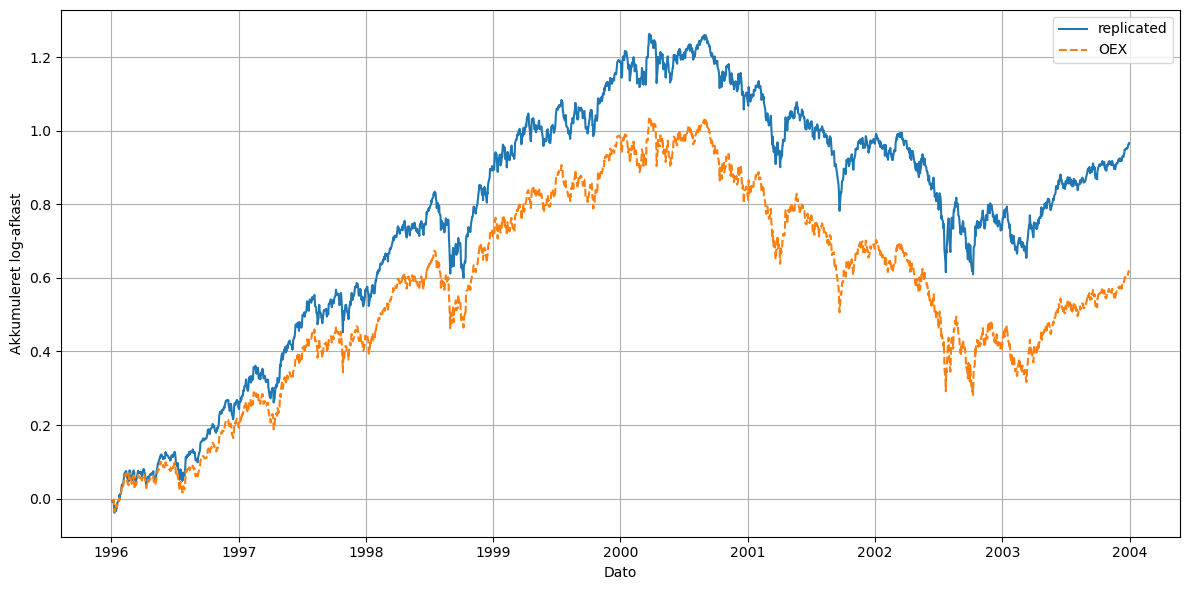

In [154]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Beregn akkumulerede log-afkast
combined_returns["log_cum_replicated"] = np.log1p(combined_returns["index_return_rep"]).cumsum()
combined_returns["log_cum_true"] = np.log1p(combined_returns["index_return"]).cumsum()

# 2. Plot
plt.figure(figsize=(12,6))
plt.plot(combined_returns["date"], combined_returns["log_cum_replicated"], label="replicated", linestyle="-")
plt.plot(combined_returns["date"], combined_returns["log_cum_true"], label="OEX", linestyle="--")
# plt.title("Akkumuleret Log-Afkast: Replikeret vs. Faktisk Indeks")
plt.xlabel("Dato")
plt.ylabel("Akkumuleret log-afkast")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


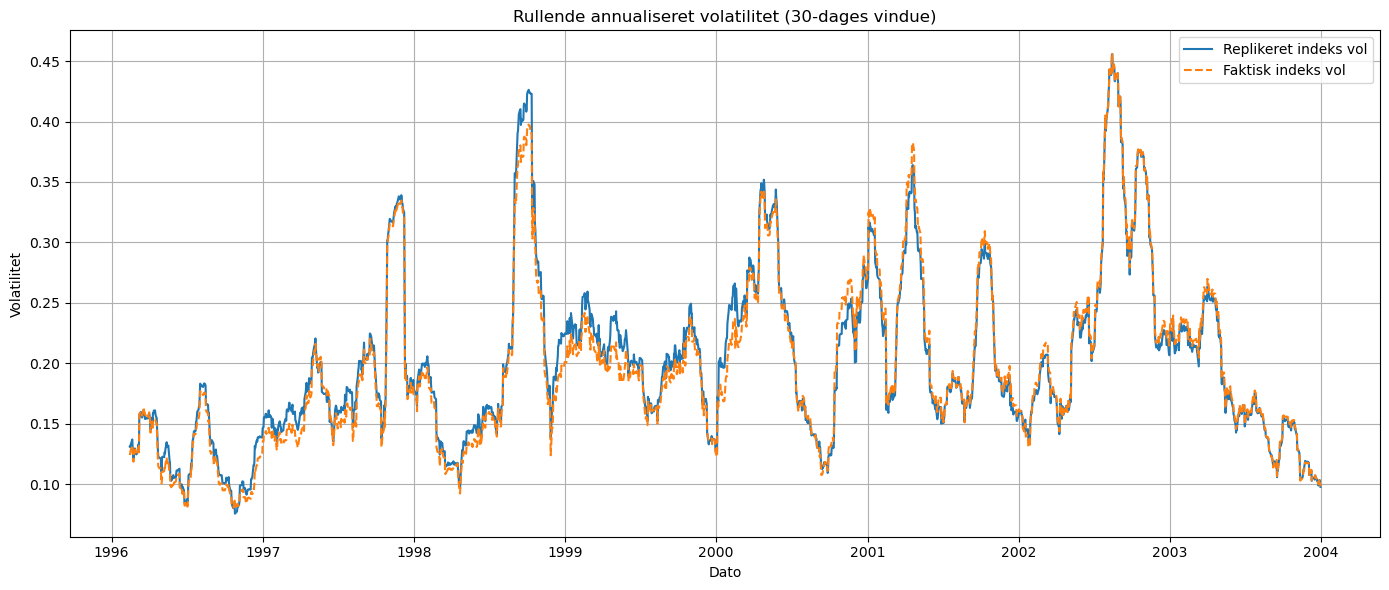

In [155]:
import matplotlib.pyplot as plt
import pandas as pd

# Beregn rullende annualiseret volatilitet
rolling_window = 30
vol_replikeret = combined_returns["index_return_rep"].rolling(rolling_window).std() * (252**0.5)
vol_faktisk = combined_returns["index_return"].rolling(rolling_window).std() * (252**0.5)

# Plot direkte med dato som x-akse
plt.figure(figsize=(14, 6))
plt.plot(combined_returns["date"], vol_replikeret, label="Replikeret indeks vol")
plt.plot(combined_returns["date"], vol_faktisk, label="Faktisk indeks vol", linestyle="--")

plt.title("Rullende annualiseret volatilitet (30-dages vindue)")
plt.xlabel("Dato")
plt.ylabel("Volatilitet")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [349]:
# import numpy as np
# import matplotlib.pyplot as plt

# # 👉 Vælg periode (tilpas disse datoer)
# start_date = "2010-01-01"
# end_date = "2024-01-01"

# # 1. Filtrér på perioden
# subset = combined_returns[
#     (combined_returns["date"] >= start_date) & 
#     (combined_returns["date"] <= end_date)
# ].copy()

# # 2. Genberegn log-afkast fra nul i valgt periode
# subset["log_cum_replicated"] = np.log1p(subset["index_return_rep"]).cumsum()
# subset["log_cum_true"] = np.log1p(subset["index_return2"]).cumsum()

# # 3. Plot
# plt.figure(figsize=(12,6))
# plt.plot(subset["date"], subset["log_cum_replicated"], label="Replikeret Indeks", linestyle="-")
# plt.plot(subset["date"], subset["log_cum_true"], label="Faktisk Indeks", linestyle="--")
# plt.title(f"Akkumuleret Log-Afkast ({start_date} til {end_date})")
# plt.xlabel("Dato")
# plt.ylabel("Akkumuleret log-afkast")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()


In [350]:
# import numpy as np
# import matplotlib.pyplot as plt

# # 1. Beregn forskellen i daglige afkast
# combined_returns["diff"] = combined_returns["index_return_rep"] - combined_returns["index_return2"]

# # 2. Plot histogram
# plt.figure(figsize=(10,6))
# plt.hist(combined_returns["diff"], bins=100, edgecolor="black")
# plt.title("Histogram over forskellen: Replikeret minus Faktisk afkast")
# plt.xlabel("Forskel (dagligt afkast)")
# plt.ylabel("Antal dage")
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # 3. (valgfrit) Udskriv statistik
# print(combined_returns["diff"].describe())


In [351]:
# # Find de rækker hvor forskellen er stor
# large_diff = combined_returns[combined_returns["diff"].abs() > 0.025]

# # Udskriv datoer + info
# print(large_diff[["date","index_return", "index_return_rep", "index_return2", "diff"]])


### for data generation: gives list of tickers

In [37]:
import pandas as pd

# Sørg for datetime-format
oex_constituents_long["date"] = pd.to_datetime(oex_constituents_long["date"])
final_df["date"] = pd.to_datetime(final_df["date"])

# Find alle tickere aktive før 2004
tickers_before_2004 = oex_constituents_long.loc[
    oex_constituents_long["date"] < "2004-01-01", "ticker"
].dropna().unique()

# Find tickere i final_df (CRSP filtreret)
tickers_in_final_df = final_df["ticker"].dropna().unique()

# Kun tickere der findes begge steder
valid_tickers = sorted(set(tickers_before_2004) & set(tickers_in_final_df))

# Lav klar til kopiering med dobbelte anførselstegn
tickers_string = ", ".join(f'"{ticker}"' for ticker in valid_tickers)

# Print resultat
print(tickers_string)


"AA", "AEP", "AES", "AIG", "ALL", "AMGN", "ATI", "AVP", "AXP", "BA", "BAC", "BAX", "BDK", "BHI", "BMY", "BNI", "BUD", "C", "CGP", "CI", "CL", "CPB", "CSC", "CSCO", "DAL", "DD", "DIS", "DOW", "EMC", "ENE", "EP", "ETR", "EXC", "F", "FDX", "G", "GBLX", "GD", "GE", "GM", "GS", "HAL", "HCA", "HD", "HET", "HIG", "HNZ", "HON", "HPQ", "HSH", "IBM", "INTC", "IP", "JCI", "JNJ", "JPM", "KO", "LEH", "MAY", "MCD", "MDT", "MER", "MMM", "MO", "MRK", "MS", "MSFT", "NSC", "NSM", "NT", "NXTL", "OMX", "ONE", "ORCL", "PARA", "PEP", "PFE", "PG", "PNU", "RAL", "ROK", "RSH", "RTN", "RTX", "S", "SLB", "SO", "T", "TOY", "TWX", "TXN", "UBAN", "UIS", "USB", "VZ", "WFC", "WMB", "WMT", "WY", "XOM", "XRX"


# Section 3.A 

### figure 1

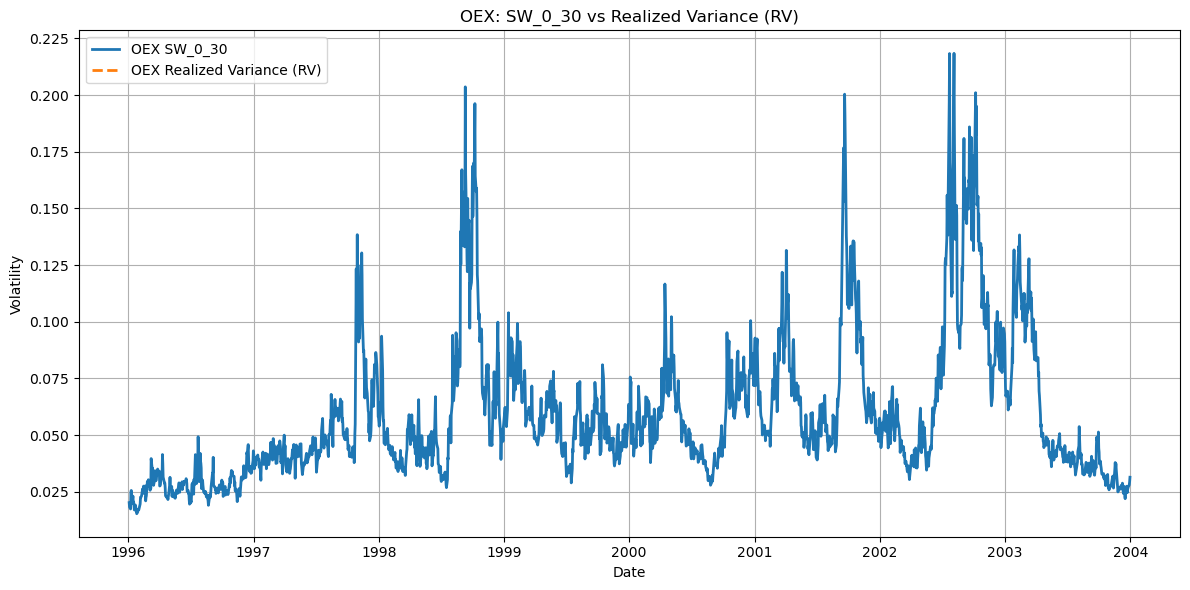

In [124]:
import matplotlib.pyplot as plt

# Filtrér for OEX
oex_data = sum_df[sum_df["ticker"] == "OEX"]

# Plot SW og Realized Variance (RV)
plt.figure(figsize=(12, 6))
plt.plot(oex_data["date"], oex_data["SW_0_30"], label="OEX SW_0_30", linewidth=2)
plt.plot(oex_data["date"], oex_data["RV"], label="OEX Realized Variance (RV)", linewidth=2, linestyle='--')
plt.title("OEX: SW_0_30 vs Realized Variance (RV)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### figure 2

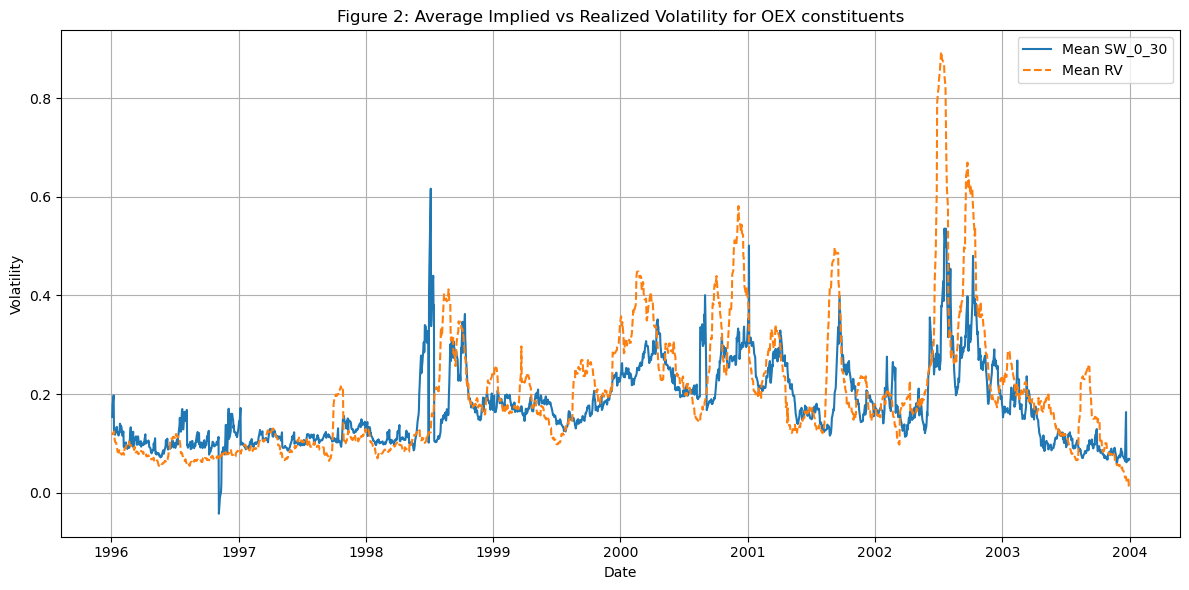

In [206]:
import pandas as pd
import matplotlib.pyplot as plt

# Filtrér alle ikke-OEX tickers
non_oex = sum_df[sum_df["ticker"] != "OEX"]

# non_oex = sum_df[(sum_df["ticker"] != "RAL") & (sum_df["ticker"] != "HET")]

# Gruppér på dato og regn ligevægtet gennemsnit
avg_sw = non_oex.groupby("date")["SW_0_30"].mean()
avg_rv = non_oex.groupby("date")["RV"].mean()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(avg_sw.index, avg_sw.values, label="Mean SW_0_30")
plt.plot(avg_rv.index, avg_rv.values, label="Mean RV", linestyle="--")
plt.title("Figure 2: Average Implied vs Realized Volatility for OEX constituents")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### investigating negative SW

In [186]:
# Find observationer med negativ SW_0_30
negatives = sum_df[sum_df["SW_0_30"] < 0]

# Find de unikke tickers
negative_tickers = negatives["ticker"].unique()

# Print som en flot streng (med " " rundt om hver ticker)
ticker_string = " ".join(negative_tickers)

print("Tickers med negative SW_0_30 værdier:\n")
print(ticker_string)


Tickers med negative SW_0_30 værdier:

TWX HET DIS IBM RAL SO


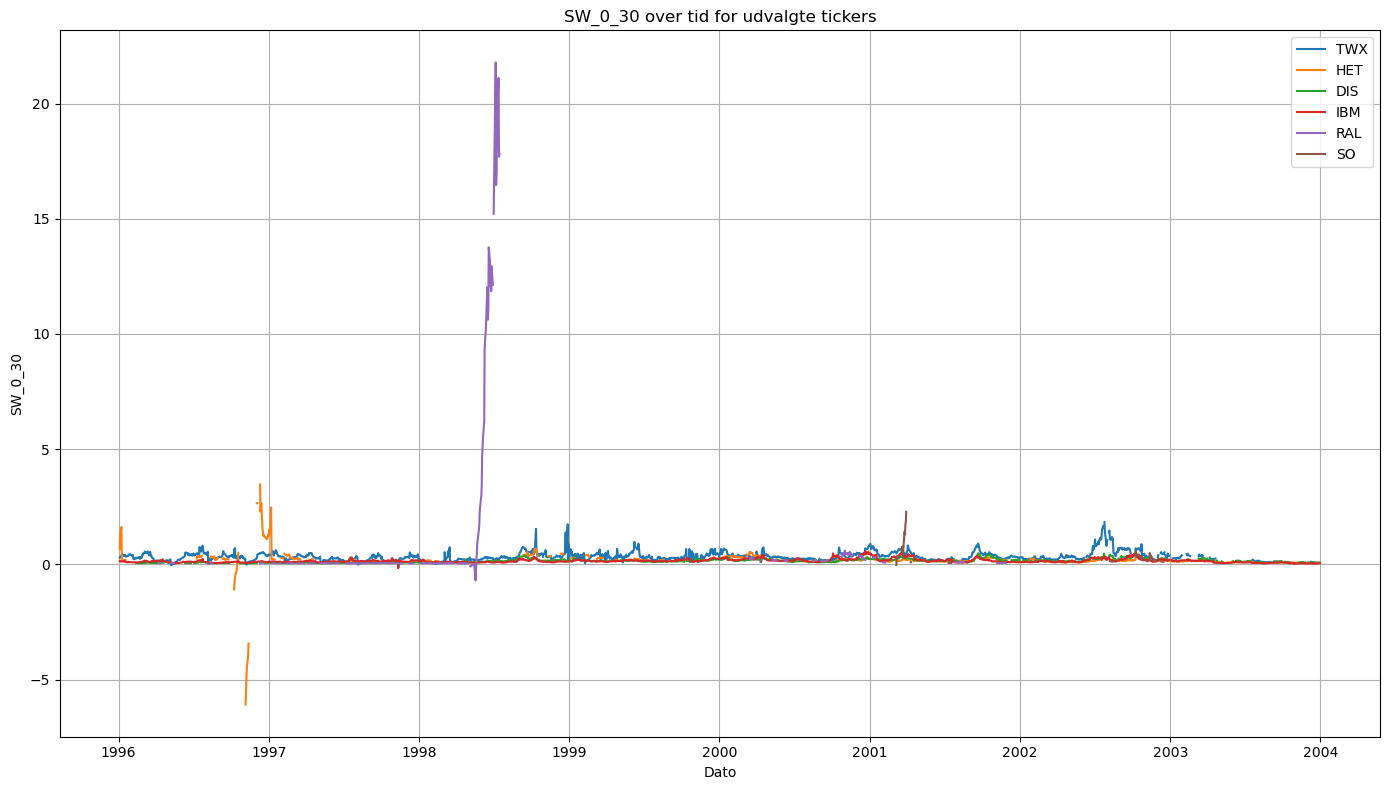

In [129]:
import matplotlib.pyplot as plt

# De tickers du vil analysere
tickers_to_plot = ["TWX", "HET", "DIS", "IBM", "RAL", "SO"]

# Filtrer data
subset = sum_df[sum_df["ticker"].isin(tickers_to_plot)]

# Plot
plt.figure(figsize=(14, 8))
for ticker in tickers_to_plot:
    ticker_data = subset[subset["ticker"] == ticker]
    plt.plot(ticker_data["date"], ticker_data["SW_0_30"], label=ticker)

plt.title("SW_0_30 over tid for udvalgte tickers")
plt.xlabel("Dato")
plt.ylabel("SW_0_30")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### merging SW and RV to return DF 

In [187]:
# Merge SW_0_30 fra sum_df over på final_df
final_df = final_df.merge(
    sum_df[["date", "ticker", "SW_0_30", "RV", "close"]],
    on=["date", "ticker"],
    how="left"
)

# (valgfrit) Tjek om der mangler noget
print(final_df.head(10))


        date ticker    weight    return  SW_0_30  RV  close
0 1996-01-03     AA  0.005556  0.016092      NaN NaN    NaN
1 1996-01-03    AEP  0.004431  0.000000      NaN NaN    NaN
2 1996-01-03    AIG  0.025526  0.006693      NaN NaN    NaN
3 1996-01-03   AMGN  0.008925 -0.010730      NaN NaN    NaN
4 1996-01-03    ATI  0.008106  0.008811      NaN NaN    NaN
5 1996-01-03    AVP  0.002964  0.011551      NaN NaN    NaN
6 1996-01-03    AXP  0.011592  0.005422      NaN NaN    NaN
7 1996-01-03     BA  0.015805 -0.009390      NaN NaN    NaN
8 1996-01-03    BAC  0.014215 -0.016886      NaN NaN    NaN
9 1996-01-03    BAX  0.006516  0.021021      NaN NaN    NaN


## investigatin EXTREME IV VALUES

### positive

In [188]:
# Sorter final_df efter 'SW_0_30' fra højest til lavest
top_swaps = final_df.sort_values(by="SW_0_30", ascending=False)

# Vis de 50 største værdier
print(top_swaps.head(50))


             date ticker    weight    return    SW_0_30        RV     close
53713  1998-07-06    RAL  0.003276 -0.013043  21.782207  0.136170  113.5000
54148  1998-07-13    RAL  0.003052 -0.001136  21.115035  0.220522  109.8750
54061  1998-07-10    RAL  0.003120 -0.014006  19.710758  0.216386  110.0000
53974  1998-07-09    RAL  0.003152 -0.014357  18.909459  0.215540  111.5625
54322  1998-07-15    RAL  0.003119 -0.006579  17.822182  0.207067  113.2500
54235  1998-07-14    RAL  0.003037  0.037543  17.690440  0.221912  114.0000
53887  1998-07-08    RAL  0.003133  0.017416  17.096725  0.214202  113.1875
53626  1998-07-02    RAL  0.003298 -0.009155  16.660431  0.136994  115.0000
53800  1998-07-07    RAL  0.003199 -0.019824  16.460579  0.203482  111.2500
53539  1998-07-01    RAL  0.003348 -0.006421  15.216962  0.134682  116.0625
52843  1998-06-19    RAL  0.003323 -0.023438  13.754640  0.073825  109.3750
108491 2001-01-04     CI  0.003247 -0.112840  13.535380  0.338513  114.0000
52930  1998-

In [201]:
od_temp = pd.read_csv(r"C:\Users\axell\Desktop\CBS\data\OptionMetrics\volpy data output\OEX_constituents_short2\t_od_raw_1998.csv")
od_temp = od_temp[od_temp['ticker'] == 'RAL'].copy()

In [202]:
# Definer fokusdatoer og konverter dem til datetime
focus_dates = pd.to_datetime([
    '1998-06-19', '1998-07-01', '1998-07-02', '1998-07-06', '1998-07-07',
    '1998-07-08', '1998-07-09', '1998-07-10', '1998-07-13', '1998-07-14', '1998-07-15'
])

# focus_dates = ['2001-01-04']

# Sørg for at 'date' kolonnen er datetime
od_temp['date'] = pd.to_datetime(od_temp['date'])

# Definer OTM condition
otm = (
    ((od_temp['cp_flag'] == 'C') & (od_temp['K'] > od_temp['F'])) |
    ((od_temp['cp_flag'] == 'P') & (od_temp['K'] < od_temp['F']))
)

# Filtrer både på datoer og OTM
ral_focus = od_temp[od_temp['date'].isin(focus_dates) & otm].copy()

# Print resultater
print(f"Antal OTM option records for RAL på kritiske datoer: {len(ral_focus)}")
ral_focus[['date', 'cp_flag', 'exdate', 'ticker', 'F', 'K', 'bid', 'ask', 'mid', 'IV', 'spread','volume']].head(10)


Antal OTM option records for RAL på kritiske datoer: 269


,date,cp_flag,exdate,ticker,F,K,bid,ask,mid,IV,spread,volume
601678,1998-06-19,P,1998-09-19,RAL,110.664536,35.000,3.000,3.3750,3.18750,1.933785,0.3750,0.0
601679,1998-06-19,P,1998-07-18,RAL,109.871708,38.375,6.250,6.7500,6.50000,4.061967,0.5000,4.0
601680,1998-06-19,P,1998-06-20,RAL,109.391982,90.000,0.000,0.0625,0.03125,NaN,0.0625,0.0
601681,1998-06-19,P,1998-07-18,RAL,109.871708,35.000,1.375,1.6250,1.50000,2.793285,0.2500,20.0
601682,1998-06-19,P,1998-06-20,RAL,109.391982,80.000,0.000,0.0625,0.03125,NaN,0.0625,0.0
601684,1998-06-19,P,1998-09-19,RAL,110.664536,90.000,0.000,0.2500,0.12500,0.218131,0.2500,0.0
601685,1998-06-19,P,1998-09-19,RAL,110.664536,40.000,11.375,12.1250,11.75000,2.890895,0.7500,0.0
601760,1998-06-19,P,1998-06-20,RAL,109.391982,105.000,0.000,0.0625,0.03125,NaN,0.0625,0.0
601832,1998-06-19,C,1998-06-20,RAL,109.391982,115.000,0.000,0.0625,0.03125,0.499152,0.0625,0.0
601835,1998-06-19,P,1998-06-20,RAL,109.391982,100.000,0.000,0.0625,0.03125,NaN,0.0625,0.0


### negative 

In [203]:
# naegtive SW
top_swaps = final_df.sort_values(by="SW_0_30", ascending=True)

# Vis de 50 største værdier
print(top_swaps.head(50))


             date ticker    weight    return   SW_0_30        RV     close
17875  1996-11-05    HET  0.000816  0.029851 -6.087384  0.087765   17.2500
17960  1996-11-06    HET  0.000831 -0.036232 -5.437214  0.079324   16.6250
18045  1996-11-07    HET  0.000787  0.000000 -4.913513  0.064119   16.6250
18130  1996-11-08    HET  0.000784  0.007519 -4.462609  0.084111   16.7500
18215  1996-11-11    HET  0.000785  0.014925 -3.987654  0.134695   17.0000
18300  1996-11-12    HET  0.000796  0.000000 -3.436095  0.139249   17.0000
16181  1996-10-08    HET  0.000930 -0.006623 -1.089207  0.120182   18.7500
16265  1996-10-09    HET  0.000928 -0.040000 -0.733241  0.135409   18.0000
50842  1998-05-18    RAL  0.003357 -0.006810 -0.696994  0.039808  109.3750
16349  1996-10-10    HET  0.000896 -0.020833 -0.616019  0.116209   17.6250
16433  1996-10-11    HET  0.000880  0.021277 -0.465729  0.111679   18.0000
50929  1998-05-19    RAL  0.003335  0.005714 -0.320107  0.043689  110.0000
16517  1996-10-14    HET 

## investigatin EXTREME RV VALUES

### positive

In [219]:
# naegtive SW
top_swaps = final_df.sort_values(by="RV", ascending=False)

# Vis de 50 største værdier
print(top_swaps.head(60))


             date ticker        weight    return   SW_0_30         RV   close
142148 2002-07-19    WMB  7.819516e-04 -0.183544  2.453046  21.562797  5.1600
141608 2002-07-11    WMB  6.047176e-04  0.092338  2.112751  21.554616  5.5600
142058 2002-07-18    WMB  7.463452e-04  0.019355  2.215447  21.553133  6.3200
141968 2002-07-17    WMB  7.218853e-04  0.045531  2.223217  21.538260  6.2000
141428 2002-07-09    WMB  6.063229e-04 -0.055556  2.002543  21.524196  5.1000
141518 2002-07-10    WMB  5.859787e-04 -0.001961  1.967665  21.498877  5.0900
141878 2002-07-16    WMB  7.044312e-04  0.008503  2.206887  21.488219  5.9300
141698 2002-07-12    WMB  6.562351e-04  0.023381  2.106906  21.452301  5.6900
141788 2002-07-15    WMB  6.774577e-04  0.033392  2.352081  21.446344  5.8800
141338 2002-07-08    WMB  6.044818e-04 -0.009174       NaN  21.384654  5.4000
142238 2002-07-22    WMB  6.657423e-04 -0.610465       NaN  21.295204  2.0100
141248 2002-07-05    WMB  6.169992e-04  0.016791       NaN  20.1

In [241]:
# Filtrer kun WMB (hvis du ikke allerede har gjort det)
wmb_df = final_df[final_df["ticker"] == "WMB"].copy()

# Sørg for korrekt sorteret data
wmb_df = wmb_df.sort_values(by="date").reset_index(drop=True)

# Tilføj return_squared
wmb_df["return_squared"] = wmb_df["return"] ** 2

# Initialiser en tom RV_v2 kolonne
rv_v2_list = []

# Brug en for-loop til at summe fremad
for idx in range(len(wmb_df)):
    future_window = wmb_df.iloc[idx:idx+21]  # 21 trading days fremad
    if len(future_window) >= 18:  # fx kræv mindst 18 tradingdage
        rv_sum = future_window["return_squared"].sum()
        rv_annualized = rv_sum * (252 / len(future_window))
        rv_v2_list.append(rv_annualized)
    else:
        rv_v2_list.append(np.nan)  # Ikke nok data fremad

# Læg listen ind som en ny kolonne
wmb_df["RV_v2"] = rv_v2_list

wmb_sorted = wmb_df.sort_values(by="RV_v2", ascending=False)
wmb_sorted.head(10)


# WMB is fine to keep. realistic RV


,date,ticker,weight,return,SW_0_30,RV,close,return_squared,RV_v2
1647,2002-07-19,WMB,0.000782,-0.183544,2.453046,21.562797,5.16,0.033688,21.562797
1641,2002-07-11,WMB,0.000605,0.092338,2.112751,21.554616,5.56,0.008526,21.554616
1646,2002-07-18,WMB,0.000746,0.019355,2.215447,21.553133,6.32,0.000375,21.553133
1645,2002-07-17,WMB,0.000722,0.045531,2.223217,21.538260,6.20,0.002073,21.538260
1639,2002-07-09,WMB,0.000606,-0.055556,2.002543,21.524196,5.10,0.003086,21.524196
1640,2002-07-10,WMB,0.000586,-0.001961,1.967665,21.498877,5.09,0.000004,21.498877
1644,2002-07-16,WMB,0.000704,0.008503,2.206887,21.488219,5.93,0.000072,21.488219
1642,2002-07-12,WMB,0.000656,0.023381,2.106906,21.452301,5.69,0.000547,21.452301
1643,2002-07-15,WMB,0.000677,0.033392,2.352081,21.446344,5.88,0.001115,21.446344
1638,2002-07-08,WMB,0.000604,-0.009174,NaN,21.384654,5.40,0.000084,21.384654


## high SW at last spike 

In [243]:
# Antag at din samlede data hedder final_df

# Vælg en relevant periode
mask = (final_df["date"] >= "2003-10-01") & (final_df["date"] <= "2004-01-31")
spike_period = final_df[mask]

# Sorter efter højeste SW_0_30 for at finde skyldige aktier
spike_sorted = spike_period.sort_values(by="SW_0_30", ascending=False)

# Print top 30
spike_sorted[['date', 'ticker', 'SW_0_30', 'RV', 'weight', 'return', 'close']].head(10)


,date,ticker,SW_0_30,RV,weight,return,close
174582,2003-12-22,PFE,4.480529,0.006730,0.049862,0.000875,34.30
172547,2003-11-19,EP,0.595823,0.231656,0.000737,0.006525,6.17
174001,2003-12-12,EP,0.522703,0.240493,0.000803,-0.007364,6.74
172638,2003-11-20,EP,0.520459,0.239178,0.000735,0.012966,6.25
172456,2003-11-18,EP,0.506027,0.303646,0.000798,-0.082335,6.13
172729,2003-11-21,EP,0.473037,0.238706,0.000752,0.019200,6.37
173730,2003-12-09,EP,0.471856,0.198673,0.000788,0.007530,6.69
173821,2003-12-10,EP,0.469265,0.210966,0.000799,0.002990,6.71
173911,2003-12-11,EP,0.458409,0.225874,0.000800,0.011922,6.79
172820,2003-11-24,EP,0.377658,0.241017,0.000767,0.028258,6.55


### investigating PFE

In [247]:
# Indlæs hele optionsfilen og filtrer med det samme
od_temp = pd.read_csv(r"C:\Users\axell\Desktop\CBS\data\OptionMetrics\volpy data output\OEX_constituents_short2\t_od_raw_2003.csv")
od_temp = od_temp[(od_temp['ticker'] == 'PFE') & (od_temp['date'] == '2003-12-22') & (od_temp['exdate'] == '2004-02-21')].copy()

# Sørg for at dato er i datetime format
od_temp['date'] = pd.to_datetime(od_temp['date'])

# Print et hurtigt overblik
print(f"Antal option records for PFE på 2003-12-22: {len(od_temp)}")
od_temp[['date', 'cp_flag', 'exdate', 'ticker', 'F', 'K', 'bid', 'ask', 'mid', 'IV', 'spread', 'volume']].sort_values(by="IV", ascending=False).head(50)


Antal option records for PFE på 2003-12-22: 26


,date,cp_flag,exdate,ticker,F,K,bid,ask,mid,IV,spread,volume
1672382,2003-12-22,P,2004-02-21,PFE,34.192866,17.5,12.90,13.70,13.300,6.643267,0.80,0.0
1672381,2003-12-22,P,2004-02-21,PFE,34.192866,12.5,8.00,8.50,8.250,6.059579,0.50,0.0
1672383,2003-12-22,P,2004-02-21,PFE,34.192866,22.5,0.00,0.05,0.025,0.463672,0.05,0.0
1671685,2003-12-22,C,2004-02-21,PFE,34.192866,22.5,11.70,12.00,11.850,0.455358,0.30,0.0
1671675,2003-12-22,C,2004-02-21,PFE,34.192866,25.0,9.30,9.50,9.400,0.430699,0.20,0.0
1671711,2003-12-22,P,2004-02-21,PFE,34.192866,25.0,0.00,0.10,0.050,0.399176,0.10,0.0
1671682,2003-12-22,C,2004-02-21,PFE,34.192866,47.5,0.00,0.05,0.025,0.357327,0.05,0.0
1671686,2003-12-22,C,2004-02-21,PFE,34.192866,27.5,6.80,7.00,6.900,0.315940,0.20,0.0
1671679,2003-12-22,C,2004-02-21,PFE,34.192866,45.0,0.00,0.05,0.025,0.306889,0.05,0.0
1673045,2003-12-22,P,2004-02-21,PFE,34.192866,27.5,0.00,0.10,0.050,0.293077,0.10,25.0


In [248]:
import pandas as pd

# Indlæs hele optionsfilen og filtrer med det samme
od_temp = pd.read_csv(r"C:\Users\axell\Desktop\CBS\data\OptionMetrics\volpy data output\OEX_constituents_short2\t_od_raw_2003.csv")

# Filtrer kun for ticker 'PFE' og dato '2003-12-22'
od_temp = od_temp[(od_temp['ticker'] == 'PFE') & (od_temp['date'] == '2003-12-22')].copy()

# Sørg for at date er datetime format
od_temp['date'] = pd.to_datetime(od_temp['date'])

# Udregn moneyness: F/K for calls, K/F for puts
od_temp['moneyness'] = od_temp.apply(
    lambda row: row['F'] / row['K'] if row['cp_flag'] == 'C' else row['K'] / row['F'],
    axis=1
)

# Udregn mid price hvis den mangler
od_temp['mid'] = (od_temp['bid'] + od_temp['ask']) / 2

# Spot outliers: f.eks. hvis IV > 300% eller mid price > 90% af forward price (ret vildt)
outliers = od_temp[
    (od_temp['IV'] > 3.0) | 
    (od_temp['mid'] > 0.9 * od_temp['F'])
].copy()

# Sorter dem der trigger outlier flag
outliers = outliers.sort_values(by="IV", ascending=False)

# Print resultater
print(f"Antal option records for PFE på 2003-12-22: {len(od_temp)}")
print(f"Antal mistænkelige optioner (outliers): {len(outliers)}")
display(outliers[['date', 'cp_flag', 'exdate', 'ticker', 'F', 'K', 'bid', 'ask', 'mid', 'IV', 'spread', 'volume', 'moneyness']])


Antal option records for PFE på 2003-12-22: 136
Antal mistænkelige optioner (outliers): 2


,date,cp_flag,exdate,ticker,F,K,bid,ask,mid,IV,spread,volume,moneyness
1672382,2003-12-22,P,2004-02-21,PFE,34.192866,17.5,12.9,13.7,13.30,6.643267,0.8,0.0,0.511803
1672381,2003-12-22,P,2004-02-21,PFE,34.192866,12.5,8.0,8.5,8.25,6.059579,0.5,0.0,0.365573


### raw  option data

In [250]:
# Indlæs raw optionsdata
od_temp_raw = pd.read_csv(r"C:\Users\axell\Desktop\CBS\data\OptionMetrics\sp100_pseudo2\option data\option data 2003.csv")

# Filtrér kun på PFE og præcis 2003-12-22 og expiration 2004-02-21
od_temp_raw = od_temp_raw[
    (od_temp_raw['ticker'] == 'PFE') &
    (od_temp_raw['date'] == '2003-12-22') &
    (od_temp_raw['exdate'] == '2004-02-21')
].copy()

# Sørg for at dato-kolonnen er i datetime format
od_temp_raw['date'] = pd.to_datetime(od_temp_raw['date'])

# Lav mid-price og spread
od_temp_raw['mid'] = (od_temp_raw['best_bid'] + od_temp_raw['best_offer']) / 2
od_temp_raw['spread'] = od_temp_raw['best_offer'] - od_temp_raw['best_bid']

# Print hurtigt overblik
print(f"Antal option records for PFE (RAW data) på 2003-12-22: {len(od_temp_raw)}")
od_temp_raw[['date', 'cp_flag', 'exdate', 'ticker', 'strike_price', 'best_bid', 'best_offer', 'mid', 'impl_volatility', 'spread', 'open_interest']].sort_values(by="impl_volatility", ascending=False).head(50)


Antal option records for PFE (RAW data) på 2003-12-22: 26


,date,cp_flag,exdate,ticker,strike_price,best_bid,best_offer,mid,impl_volatility,spread,open_interest
850141,2003-12-22,P,2004-02-21,PFE,17500.0,12.90,13.70,13.300,6.643267,0.80,0.0
850140,2003-12-22,P,2004-02-21,PFE,12500.0,8.00,8.50,8.250,6.059579,0.50,0.0
850142,2003-12-22,P,2004-02-21,PFE,22500.0,0.00,0.05,0.025,0.463672,0.05,0.0
850089,2003-12-22,C,2004-02-21,PFE,22500.0,11.70,12.00,11.850,0.455358,0.30,0.0
850079,2003-12-22,C,2004-02-21,PFE,25000.0,9.30,9.50,9.400,0.430699,0.20,0.0
850132,2003-12-22,P,2004-02-21,PFE,25000.0,0.00,0.10,0.050,0.399176,0.10,0.0
850086,2003-12-22,C,2004-02-21,PFE,47500.0,0.00,0.05,0.025,0.357327,0.05,0.0
850090,2003-12-22,C,2004-02-21,PFE,27500.0,6.80,7.00,6.900,0.315940,0.20,0.0
850083,2003-12-22,C,2004-02-21,PFE,45000.0,0.00,0.05,0.025,0.306889,0.05,0.0
850143,2003-12-22,P,2004-02-21,PFE,27500.0,0.00,0.10,0.050,0.293077,0.10,0.0


In [ ]:
# import pandas as pd
# import numpy as np

# def detect_simple_monotonic_arbitrage_fast(df, abs_tolerance=0.5, pct_tolerance=0.2):
#     df = df.copy()
#     df["simple_arb_flag"] = 0

#     df = df.sort_values(["ticker", "date", "exdate", "cp_flag", "moneyness", "mid"]).reset_index(drop=True)

#     df["group_id"] = df.groupby(["ticker", "date", "exdate", "cp_flag"]).ngroup()

#     is_call = (df["cp_flag"] == "C")
#     is_put = (df["cp_flag"] == "P")

#     # Shifts
#     df["next_mid"] = df.groupby("group_id")["mid"].shift(-1)
#     df["prev_mid"] = df.groupby("group_id")["mid"].shift(1)

#     valid_next = df["next_mid"].notna()
#     valid_prev = df["prev_mid"].notna()

#     # For puts: check fremad
#     mid_diff_put = df["next_mid"] - df["mid"]

#     # For calls: check bagud
#     mid_diff_call = df["mid"] - df["prev_mid"]

#     # Absolut/Relativ check for puts
#     put_small_price = df["mid"] < 2
#     put_large_price = df["mid"] >= 2

#     put_arbitrage_abs = valid_next & is_put & put_small_price & (mid_diff_put < -abs_tolerance)
#     put_arbitrage_pct = valid_next & is_put & put_large_price & ((mid_diff_put / df["mid"]) < -pct_tolerance)

#     # Absolut/Relativ check for calls
#     call_small_price = df["prev_mid"] < 2
#     call_large_price = df["prev_mid"] >= 2

#     call_arbitrage_abs = valid_prev & is_call & call_small_price & (mid_diff_call > abs_tolerance)
#     call_arbitrage_pct = valid_prev & is_call & call_large_price & ((mid_diff_call / df["prev_mid"]) > pct_tolerance)

#     # Combine
#     arbitrage = put_arbitrage_abs | put_arbitrage_pct | call_arbitrage_abs | call_arbitrage_pct

#     df.loc[arbitrage, "simple_arb_flag"] = 1

#     # Lav group_summary
#     group_summary = df.groupby(["ticker", "date", "exdate", "cp_flag"]).agg(
#         n_options=("mid", "count"),
#         has_arbitrage=("simple_arb_flag", "max")
#     ).reset_index()

#     return df.drop(columns=["group_id"]), group_summary #, "next_mid", "prev_mid"




# def clean_iterative_simple_arbitrage(df, abs_tolerance=0.5, pct_tolerance=0.2, verbose = True):
#     df_current = df.copy()
#     iteration = 0
#     total_removed = 0

#     while True:
#         iteration += 1

#         # Kør arbitrage detection
#         df_current, group_summary = detect_simple_monotonic_arbitrage_fast(df_current, abs_tolerance=abs_tolerance, pct_tolerance=pct_tolerance)

#         # Antal observationer med arbitrage
#         n_arbs = df_current["simple_arb_flag"].sum()

#         if verbose:
#             print(f"Iteration {iteration}: {n_arbs} arbitrage observationer fundet")

#         if n_arbs == 0:
#             break  # færdig

#         # Fjern dem
#         total_removed += n_arbs
#         df_current = df_current[df_current["simple_arb_flag"] == 0].reset_index(drop=True)


#     return df_current


In [ ]:
### denne version er fin til exploration

import pandas as pd
import numpy as np

def detect_monotonic_conflicts_extended(df, abs_tolerance=0.5, pct_tolerance=0.1):
    df = df.copy()
    df = df.sort_values(["ticker", "date", "exdate", "cp_flag", "moneyness", "mid"]).reset_index(drop=True)

    df["group_id"] = df.groupby(["ticker", "date", "exdate", "cp_flag"]).ngroup()

    # Shifts
    df["prev1_mid"] = df.groupby("group_id")["mid"].shift(1)
    df["next1_mid"] = df.groupby("group_id")["mid"].shift(-1)
    df["next2_mid"] = df.groupby("group_id")["mid"].shift(-2)
    df["next3_mid"] = df.groupby("group_id")["mid"].shift(-3)

    is_call = (df["cp_flag"] == "C")
    is_put = (df["cp_flag"] == "P")

    # Konflikt-kolonner
    df["prev1"] = 0
    df["next1"] = 0
    df["next2"] = 0
    df["next3"] = 0

    small_price = df["mid"] < 2
    large_price = ~small_price

    # Logik for CALLS
    df.loc[is_call & small_price & (df["next1_mid"] > df["mid"] + abs_tolerance), "next1"] = 1
    df.loc[is_call & large_price & ((df["next1_mid"] - df["mid"]) / df["mid"] > pct_tolerance), "next1"] = 1

    df.loc[is_call & small_price & (df["next2_mid"] > df["mid"] + abs_tolerance), "next2"] = 1
    df.loc[is_call & large_price & ((df["next2_mid"] - df["mid"]) / df["mid"] > pct_tolerance), "next2"] = 1

    df.loc[is_call & small_price & (df["next3_mid"] > df["mid"] + abs_tolerance), "next3"] = 1
    df.loc[is_call & large_price & ((df["next3_mid"] - df["mid"]) / df["mid"] > pct_tolerance), "next3"] = 1

    df.loc[is_call & small_price & (df["prev1_mid"] < df["mid"] - abs_tolerance), "prev1"] = 1
    df.loc[is_call & large_price & ((df["mid"] - df["prev1_mid"]) / df["prev1_mid"] > pct_tolerance), "prev1"] = 1

    # Logik for PUTS
    df.loc[is_put & small_price & (df["next1_mid"] < df["mid"] - abs_tolerance), "next1"] = 1
    df.loc[is_put & large_price & ((df["mid"] - df["next1_mid"]) / df["mid"] > pct_tolerance), "next1"] = 1

    df.loc[is_put & small_price & (df["next2_mid"] < df["mid"] - abs_tolerance), "next2"] = 1
    df.loc[is_put & large_price & ((df["mid"] - df["next2_mid"]) / df["mid"] > pct_tolerance), "next2"] = 1

    df.loc[is_put & small_price & (df["next3_mid"] < df["mid"] - abs_tolerance), "next3"] = 1
    df.loc[is_put & large_price & ((df["mid"] - df["next3_mid"]) / df["mid"] > pct_tolerance), "next3"] = 1

    df.loc[is_put & small_price & (df["prev1_mid"] > df["mid"] + abs_tolerance), "prev1"] = 1
    df.loc[is_put & large_price & ((df["prev1_mid"] - df["mid"]) / df["prev1_mid"] > pct_tolerance), "prev1"] = 1

    # Samlet flag
    df["simple_arb_flag"] = df[["prev1", "next1", "next2", "next3"]].max(axis=1)

    # Konfliktsum
    df["conflict_score"] = df[["prev1", "next1", "next2", "next3"]].sum(axis=1)

    # Group summary
    group_summary = df.groupby(["ticker", "date", "exdate", "cp_flag"]).agg(
        n_options=("mid", "count"),
        has_arbitrage=("simple_arb_flag", "max")
    ).reset_index()

    return df.drop(columns=["group_id"]), group_summary


In [647]:
import pandas as pd
import numpy as np

def detect_conflict_pct_only(df):
    df = df.copy()
    df = df.sort_values(["ticker", "date", "exdate", "cp_flag", "moneyness", "mid"]).reset_index(drop=True)

    # Tildel group id
    df["group_id"] = df.groupby(["ticker", "date", "exdate", "cp_flag"]).ngroup()

    # Opret tomme kolonner
    df["prev_conflict_rate"] = 0.0
    df["next_conflict_rate"] = 0.0

    # Løkke over grupper
    for group_id, group in df.groupby("group_id"):
        idx = group.index
        mids = group["mid"].values
        cp_flag = group["cp_flag"].iloc[0]
        n = len(mids)

        prev_conflict = np.zeros(n)
        next_conflict = np.zeros(n)

        for i in range(n):
            # Tidligere strikes
            if i > 0:
                prev_mids = mids[:i]
                if cp_flag == "C":
                    prev_conflict[i] = np.mean(prev_mids < mids[i])
                else:
                    prev_conflict[i] = np.mean(prev_mids > mids[i])
            else:
                prev_conflict[i] = 0  # Ingen tidligere -> 0

            # Kommende strikes
            if i < n - 1:
                next_mids = mids[i+1:]
                if cp_flag == "C":
                    next_conflict[i] = np.mean(next_mids > mids[i])
                else:
                    next_conflict[i] = np.mean(next_mids < mids[i])
            else:
                next_conflict[i] = 0  # Ingen kommende -> 0

        df.loc[idx, "prev_conflict_rate"] = prev_conflict
        df.loc[idx, "next_conflict_rate"] = next_conflict

    # Lav samlet conflict_rate
    df["combined_conflict_rate"] = df["prev_conflict_rate"] + df["next_conflict_rate"]

    # Definer arb flag
    df["conflict_arb_flag"] = (df["combined_conflict_rate"] >= 1.0).astype(int)

    # Lav group summary
    group_summary = df.groupby(["ticker", "date", "exdate", "cp_flag"]).agg(
        n_options=("mid", "count"),
        has_conflict=("conflict_arb_flag", "max")
    ).reset_index()

    return df.drop(columns=["group_id"]), group_summary


In [666]:
import pandas as pd
import numpy as np

def detect_conflict_pct_only_fast(df):
    df = df.copy()
    df = df.sort_values(["ticker", "date", "exdate", "cp_flag", "moneyness", "mid"]).reset_index(drop=True)

    # Assign group id
    df["group_id"] = df.groupby(["ticker", "date", "exdate", "cp_flag"]).ngroup()

    df["prev_conflict_rate"] = 0.0
    df["next_conflict_rate"] = 0.0

    results = []

    for group_id, group in df.groupby("group_id", group_keys=False):
        mids = group["mid"].values
        cp_flag = group["cp_flag"].iloc[0]
        n = len(mids)

        if n < 2:
            prev_rates = np.zeros(n)
            next_rates = np.zeros(n)
        else:
            mids_matrix = np.tile(mids, (n, 1))

            if cp_flag == "C":
                prev_conflicts = (mids_matrix[:, :].T < mids).T
                next_conflicts = (mids_matrix[:, :].T > mids).T
            else:
                prev_conflicts = (mids_matrix[:, :].T > mids).T
                next_conflicts = (mids_matrix[:, :].T < mids).T

            np.fill_diagonal(prev_conflicts, False)
            np.fill_diagonal(next_conflicts, False)

            prev_rates = np.zeros(n)
            next_rates = np.zeros(n)

            for i in range(n):
                if i >= 3:
                    prev_rates[i] = prev_conflicts[i, :i].mean()
                else:
                    prev_rates[i] = 0  # Mindre end 3 før -> 0

                if (n - i - 1) >= 3:
                    next_rates[i] = next_conflicts[i, (i+1):].mean()
                else:
                    next_rates[i] = 0  # Mindre end 3 efter -> 0

        result = pd.DataFrame({
            "index": group.index,
            "prev_conflict_rate": prev_rates,
            "next_conflict_rate": next_rates
        })
        results.append(result)

    conflict_rates_df = pd.concat(results).set_index("index")
    df.loc[conflict_rates_df.index, ["prev_conflict_rate", "next_conflict_rate"]] = conflict_rates_df[["prev_conflict_rate", "next_conflict_rate"]]

    df["combined_conflict_rate"] = df["prev_conflict_rate"] + df["next_conflict_rate"]
    df["conflict_arb_flag"] = (df["combined_conflict_rate"] >= 1.0).astype(int)

    group_summary = df.groupby(["ticker", "date", "exdate", "cp_flag"]).agg(
        n_options=("mid", "count"),
        has_conflict=("conflict_arb_flag", "max")
    ).reset_index()

    return df.drop(columns=["group_id"]), group_summary


In [696]:
import pandas as pd
import numpy as np

def detect_conflict_pct_only_fast_v2(df):
    df = df.copy()
    df = df.sort_values(["ticker", "date", "exdate", "cp_flag", "moneyness", "mid"]).reset_index(drop=True)

    # Assign group id
    df["group_id"] = df.groupby(["ticker", "date", "exdate", "cp_flag"]).ngroup()

    df["prev_conflict_rate"] = 0.0
    df["next_conflict_rate"] = 0.0

    results = []

    for group_id, group in df.groupby("group_id", group_keys=False):
        mids = group["mid"].values
        cp_flag = group["cp_flag"].iloc[0]
        n = len(mids)

        if n < 2:
            prev_rates = np.zeros(n)
            next_rates = np.zeros(n)
        else:
            mids_matrix = np.tile(mids, (n, 1))

            if cp_flag == "C":
                prev_conflicts = (mids_matrix[:, :].T < mids).T
                next_conflicts = (mids_matrix[:, :].T > mids).T
            else:
                prev_conflicts = (mids_matrix[:, :].T > mids).T
                next_conflicts = (mids_matrix[:, :].T < mids).T

            np.fill_diagonal(prev_conflicts, False)
            np.fill_diagonal(next_conflicts, False)

            prev_rates = np.zeros(n)
            next_rates = np.zeros(n)

            for i in range(n):
                if i >= 3:
                    prev_rates[i] = prev_conflicts[i, :i].mean()
                else:
                    prev_rates[i] = 0  # Mindre end 3 før -> 0

                if (n - i - 1) >= 3:
                    next_rates[i] = next_conflicts[i, (i+1):].mean()
                else:
                    next_rates[i] = 0  # Mindre end 3 efter -> 0

            # Nu justerer vi:
            for i in range(n):
                if i < 3:  # ikke nok prev
                    next_rates[i] = next_rates[i] * 1.1
                if (n - i - 1) < 3:  # ikke nok next
                    prev_rates[i] = prev_rates[i] * 1.1

        result = pd.DataFrame({
            "index": group.index,
            "prev_conflict_rate": prev_rates,
            "next_conflict_rate": next_rates
        })
        results.append(result)

    conflict_rates_df = pd.concat(results).set_index("index")
    df.loc[conflict_rates_df.index, ["prev_conflict_rate", "next_conflict_rate"]] = conflict_rates_df[["prev_conflict_rate", "next_conflict_rate"]]

    df["combined_conflict_rate"] = df["prev_conflict_rate"] + df["next_conflict_rate"]
    df["conflict_arb_flag"] = (df["combined_conflict_rate"] > 1.0).astype(int)

    group_summary = df.groupby(["ticker", "date", "exdate", "cp_flag"]).agg(
        n_options=("mid", "count"),
        has_conflict=("conflict_arb_flag", "max")
    ).reset_index()

    return df.drop(columns=["group_id"]), group_summary


In [708]:
import pandas as pd
import numpy as np

def detect_conflict_pct_only_fast_v3(df):
    df = df.copy()
    df = df.sort_values(["ticker", "date", "exdate", "cp_flag", "moneyness", "mid"]).reset_index(drop=True)

    df["group_id"] = df.groupby(["ticker", "date", "exdate", "cp_flag"]).ngroup()

    df["prev_conflict_rate"] = 0.0
    df["next_conflict_rate"] = 0.0

    results = []

    for group_id, group in df.groupby("group_id", group_keys=False):
        mids = group["mid"].values
        cp_flag = group["cp_flag"].iloc[0]
        n = len(mids)

        mids_matrix = np.tile(mids, (n, 1))

        if cp_flag == "C":
            prev_conflicts = (mids_matrix[:, :].T < mids).T
            next_conflicts = (mids_matrix[:, :].T > mids).T
        else:
            prev_conflicts = (mids_matrix[:, :].T > mids).T
            next_conflicts = (mids_matrix[:, :].T < mids).T

        np.fill_diagonal(prev_conflicts, False)
        np.fill_diagonal(next_conflicts, False)

        prev_rates = np.zeros(n)
        next_rates = np.zeros(n)

        for i in range(n):
            # Prev
            if i > 0:
                prev_rates[i] = prev_conflicts[i, :i].mean()
                if i < 3:
                    prev_rates[i] *= 0.5  # 1-2 strikes før -> dæmp med 0.5
            else:
                prev_rates[i] = 0

            # Next
            if i < n - 1:
                next_rates[i] = next_conflicts[i, (i+1):].mean()
                if (n - i - 1) < 3:
                    next_rates[i] *= 0.5  # 1-2 strikes efter -> dæmp med 0.5
            else:
                next_rates[i] = 0

            # Justering for yderste rækker (kun første og sidste observation!)
            if i == 0:
                next_rates[i] *= 1.1  # Kun første række -> justér next
            if i == n - 1:
                prev_rates[i] *= 1.1  # Kun sidste række -> justér prev

        result = pd.DataFrame({
            "index": group.index,
            "prev_conflict_rate": prev_rates,
            "next_conflict_rate": next_rates
        })
        results.append(result)

    conflict_rates_df = pd.concat(results).set_index("index")
    df.loc[conflict_rates_df.index, ["prev_conflict_rate", "next_conflict_rate"]] = conflict_rates_df[["prev_conflict_rate", "next_conflict_rate"]]

    df["combined_conflict_rate"] = df["prev_conflict_rate"] + df["next_conflict_rate"]
    df["conflict_arb_flag"] = (df["combined_conflict_rate"] > 1.0).astype(int)

    group_summary = df.groupby(["ticker", "date", "exdate", "cp_flag"]).agg(
        n_options=("mid", "count"),
        has_conflict=("conflict_arb_flag", "max")
    ).reset_index()

    return df.drop(columns=["group_id"]), group_summary


In [739]:
import pandas as pd
import numpy as np

def detect_conflict_pct_only_v4(df):
    df = df.copy()
    df = df.sort_values(["ticker", "date", "exdate", "cp_flag", "moneyness", "mid"]).reset_index(drop=True)

    df["group_id"] = df.groupby(["ticker", "date", "exdate", "cp_flag"]).ngroup()

    df["prev_conflict_rate"] = 0.0
    df["next_conflict_rate"] = 0.0

    results = []

    for group_id, group in df.groupby("group_id", group_keys=False):
        mids = group["mid"].values
        cp_flag = group["cp_flag"].iloc[0]
        n = len(mids)

        if n < 2:
            prev_rates = np.zeros(n)
            next_rates = np.zeros(n)
        else:
            mids_matrix = np.tile(mids, (n, 1))

            if cp_flag == "C":
                prev_conflicts = (mids_matrix[:, :].T < mids).T
                next_conflicts = (mids_matrix[:, :].T > mids).T
            else:
                prev_conflicts = (mids_matrix[:, :].T > mids).T
                next_conflicts = (mids_matrix[:, :].T < mids).T

            np.fill_diagonal(prev_conflicts, False)
            np.fill_diagonal(next_conflicts, False)

            prev_rates = np.zeros(n)
            next_rates = np.zeros(n)

            for i in range(n):
                prev_rates[i] = prev_conflicts[i, :i].mean() if i > 0 else 0
                next_rates[i] = next_conflicts[i, (i+1):].mean() if i < n-1 else 0

        result = pd.DataFrame({
            "index": group.index,
            "prev_conflict_rate": prev_rates,
            "next_conflict_rate": next_rates
        })
        results.append(result)

    conflict_rates_df = pd.concat(results).set_index("index")
    df.loc[conflict_rates_df.index, ["prev_conflict_rate", "next_conflict_rate"]] = conflict_rates_df[["prev_conflict_rate", "next_conflict_rate"]]

    df["combined_conflict_rate"] = df["prev_conflict_rate"] + df["next_conflict_rate"]
    df["conflict_arb_flag"] = (df["combined_conflict_rate"] >= 1.0).astype(int)

    ### --- NY DEL: Beregn BIG_FLAG --- ###

    df["big_flag"] = 0

    for group_id, group in df.groupby("group_id", group_keys=False):
        mids = group["mid"].values
        cp_flag = group["cp_flag"].iloc[0]
        n = len(mids)

        for i in range(n):
            if group["conflict_arb_flag"].iloc[i] == 1:
                mid = mids[i]

                # Forhold ift. tidligere
                if i > 0:
                    prev_mids = mids[:i]
                    if len(prev_mids) > 0:
                        prev_ratio = np.mean(mid / prev_mids)

                        if cp_flag == "C" and prev_ratio > 2:
                            df.loc[group.index[i], "big_flag"] = 1
                        if cp_flag == "P" and prev_ratio < 0.5:
                            df.loc[group.index[i], "big_flag"] = 1

                # Forhold ift. næste
                if i < n-1:
                    next_mids = mids[(i+1):]
                    if len(next_mids) > 0:
                        next_ratio = np.mean(mid / next_mids)

                        if cp_flag == "C" and next_ratio < 0.5:
                            df.loc[group.index[i], "big_flag"] = 1
                        if cp_flag == "P" and next_ratio > 2:
                            df.loc[group.index[i], "big_flag"] = 1

    # Lav group summary
    group_summary = df.groupby(["ticker", "date", "exdate", "cp_flag"]).agg(
        n_options=("mid", "count"),
        has_conflict=("conflict_arb_flag", "max"),
        has_big_conflict=("big_flag", "max")
    ).reset_index()

    return df.drop(columns=["group_id"]), group_summary


In [748]:
import pandas as pd
import numpy as np

def detect_conflict_pct_only_v5(df, forhold_threshold=2.0, diff_threshold=0.5):
    df = df.copy()
    df = df.sort_values(["ticker", "date", "exdate", "cp_flag", "moneyness", "mid"]).reset_index(drop=True)

    df["group_id"] = df.groupby(["ticker", "date", "exdate", "cp_flag"]).ngroup()

    df["prev_conflict_rate"] = 0.0
    df["next_conflict_rate"] = 0.0

    results = []

    for group_id, group in df.groupby("group_id", group_keys=False):
        mids = group["mid"].values
        cp_flag = group["cp_flag"].iloc[0]
        n = len(mids)

        if n < 2:
            prev_rates = np.zeros(n)
            next_rates = np.zeros(n)
        else:
            mids_matrix = np.tile(mids, (n, 1))

            if cp_flag == "C":
                prev_conflicts = (mids_matrix[:, :].T < mids).T
                next_conflicts = (mids_matrix[:, :].T > mids).T
            else:
                prev_conflicts = (mids_matrix[:, :].T > mids).T
                next_conflicts = (mids_matrix[:, :].T < mids).T

            np.fill_diagonal(prev_conflicts, False)
            np.fill_diagonal(next_conflicts, False)

            prev_rates = np.zeros(n)
            next_rates = np.zeros(n)

            for i in range(n):
                prev_rates[i] = prev_conflicts[i, :i].mean() if i > 0 else 0
                next_rates[i] = next_conflicts[i, (i+1):].mean() if i < n-1 else 0

        result = pd.DataFrame({
            "index": group.index,
            "prev_conflict_rate": prev_rates,
            "next_conflict_rate": next_rates
        })
        results.append(result)

    conflict_rates_df = pd.concat(results).set_index("index")
    df.loc[conflict_rates_df.index, ["prev_conflict_rate", "next_conflict_rate"]] = conflict_rates_df[["prev_conflict_rate", "next_conflict_rate"]]

    df["combined_conflict_rate"] = df["prev_conflict_rate"] + df["next_conflict_rate"]
    df["conflict_arb_flag"] = (df["combined_conflict_rate"] >= 1.0).astype(int)

    ### --- NY DEL: Beregn BIG_FLAG med forhold OG difference --- ###
    df["big_flag"] = 0

    for group_id, group in df.groupby("group_id", group_keys=False):
        mids = group["mid"].values
        cp_flag = group["cp_flag"].iloc[0]
        n = len(mids)

        for i in range(n):
            if group["conflict_arb_flag"].iloc[i] == 1:
                mid = mids[i]
                prev_mids = mids[:i]
                next_mids = mids[(i+1):]

                # Tjek prev
                if len(prev_mids) > 0:
                    prev_ratio = np.mean(mid / prev_mids)
                    prev_diff = np.mean(np.abs(mid - prev_mids))

                    if cp_flag == "C" and prev_ratio > forhold_threshold and prev_diff > diff_threshold:
                        df.loc[group.index[i], "big_flag"] = 1
                    if cp_flag == "P" and prev_ratio < 1/forhold_threshold and prev_diff > diff_threshold:
                        df.loc[group.index[i], "big_flag"] = 1

                # Tjek next
                if len(next_mids) > 0:
                    next_ratio = np.mean(mid / next_mids)
                    next_diff = np.mean(np.abs(mid - next_mids))

                    if cp_flag == "C" and next_ratio < 1/forhold_threshold and next_diff > diff_threshold:
                        df.loc[group.index[i], "big_flag"] = 1
                    if cp_flag == "P" and next_ratio > forhold_threshold and next_diff > diff_threshold:
                        df.loc[group.index[i], "big_flag"] = 1

    # Lav group summary
    group_summary = df.groupby(["ticker", "date", "exdate", "cp_flag"]).agg(
        n_options=("mid", "count"),
        has_conflict=("conflict_arb_flag", "max"),
        has_big_conflict=("big_flag", "max")
    ).reset_index()

    return df.drop(columns=["group_id"]), group_summary


In [757]:
od_temp = pd.read_csv(r"C:\Users\axell\Desktop\CBS\data\OptionMetrics\volpy data output\OEX_constituents_short2\t_od_rdy_2003.csv")
od_temp["moneyness"] = od_temp["K"] / od_temp["F"]
od_temp = od_temp.dropna(subset=["IV", "mid", "K", "F"])

In [ ]:
# slow version

# Kør konflikt-detektion på din od_temp
od_temp_with_conflict, conflict_summary = detect_conflict_pct_only(od_temp)

# Hvor mange grupper har konflikt?
antal_conflict_grupper = conflict_summary["has_conflict"].sum()

print(f"Antal grupper med konflikt: {antal_conflict_grupper}")


In [736]:
# fast version

od_temp_with_conflict, conflict_summary = detect_conflict_pct_only_fast(od_temp)

# Hvor mange grupper har konflikt?
antal_conflict_grupper = conflict_summary["has_conflict"].sum()

print(f"Antal grupper med konflikt: {antal_conflict_grupper}")

Antal grupper med konflikt: 631


In [733]:
# fast version v2

od_temp_with_conflict, conflict_summary = detect_conflict_pct_only_fast_v2(od_temp)

# Hvor mange grupper har konflikt?
antal_conflict_grupper = conflict_summary["has_conflict"].sum()

print(f"Antal grupper med konflikt: {antal_conflict_grupper}")

Antal grupper med konflikt: 161


In [716]:
# fast version v3

od_temp_with_conflict, conflict_summary = detect_conflict_pct_only_fast_v3(od_temp)

# Hvor mange grupper har konflikt?
antal_conflict_grupper = conflict_summary["has_conflict"].sum()

print(f"Antal grupper med konflikt: {antal_conflict_grupper}")

Antal grupper med konflikt: 20


In [ ]:
# Kør funktionen på din od_temp v4 
od_temp_with_conflict, conflict_summary = detect_conflict_pct_only_v4(od_temp)

# Antal grupper med simpel konflikt
antal_conflict_grupper = conflict_summary["has_conflict"].sum()

# Antal grupper med stor konflikt
antal_big_conflict_grupper = conflict_summary["has_big_conflict"].sum()

print(f"Antal grupper med simpel konflikt: {antal_conflict_grupper}")
print(f"Antal grupper med stor konflikt: {antal_big_conflict_grupper}")

,ticker,date,exdate,cp_flag,n_options,has_conflict,has_big_conflict
0,AEP,2003-01-02,2003-01-18,C,14,1,1
1,AEP,2003-01-02,2003-01-18,P,11,1,1
2,AEP,2003-01-02,2003-02-22,C,11,0,0
3,AEP,2003-01-02,2003-02-22,P,8,0,0
4,AEP,2003-01-02,2003-05-17,C,9,0,0


In [758]:
# Kør v5
od_temp_with_conflict, conflict_summary = detect_conflict_pct_only_v5(od_temp)

# Hvor mange har conflicts?
print("Antal grupper med konflikt:", conflict_summary["has_conflict"].sum())

# Hvor mange har big conflicts?
print("Antal grupper med BIG konflikt:", conflict_summary["has_big_conflict"].sum())

# Hvis du vil se dem:
conflict_summary[conflict_summary["has_big_conflict"] == 1].head()


Antal grupper med konflikt: 42
Antal grupper med BIG konflikt: 7


,ticker,date,exdate,cp_flag,n_options,has_conflict,has_big_conflict
31787,MMM,2003-09-22,2003-11-22,P,6,1,1
31791,MMM,2003-09-23,2003-11-22,P,6,1,1
31795,MMM,2003-09-24,2003-11-22,P,6,1,1
31799,MMM,2003-09-25,2003-11-22,P,6,1,1
31803,MMM,2003-09-26,2003-11-22,P,6,1,1


In [791]:
# Først: filtrér grupper med konflikt
conflict_groups = conflict_summary[conflict_summary["has_big_conflict"] == 1]

# Træk et tilfældigt eksempel
example_group = conflict_groups.sample(1)  # random_state=42 for at få samme resultat hver gang (kan fjernes)

# Filtrer fra hele datasættet
example_data = od_temp_with_conflict[
    (od_temp_with_conflict["ticker"] == example_group["ticker"].values[0]) &
    (od_temp_with_conflict["date"] == example_group["date"].values[0]) &
    (od_temp_with_conflict["exdate"] == example_group["exdate"].values[0]) &
    (od_temp_with_conflict["cp_flag"] == example_group["cp_flag"].values[0])
]

# Udskriv relevante kolonner
example_data[
    ["date", "ticker", "exdate", "cp_flag", "F", "K","IV", "moneyness", "mid",
     "prev_conflict_rate", "next_conflict_rate", "combined_conflict_rate", "conflict_arb_flag"]
]


,date,ticker,exdate,cp_flag,F,K,IV,moneyness,mid,prev_conflict_rate,next_conflict_rate,combined_conflict_rate,conflict_arb_flag
124015,2003-12-22,PFE,2004-02-21,P,34.192866,12.5,6.059579,0.365573,8.250,0.000000,0.666667,0.666667,0
124016,2003-12-22,PFE,2004-02-21,P,34.192866,17.5,6.643267,0.511803,13.300,0.000000,1.000000,1.000000,1
124017,2003-12-22,PFE,2004-02-21,P,34.192866,30.0,0.247674,0.877376,0.150,1.000000,0.000000,1.000000,1
124018,2003-12-22,PFE,2004-02-21,P,34.192866,32.5,0.206835,0.950491,0.475,0.666667,0.000000,0.666667,0


In [787]:
# Gruppering på ticker-niveau
ticker_summary = conflict_summary.groupby("ticker").agg(
    total_groups=("ticker", "count"),
    conflict_groups=("has_conflict", "sum"),
    big_conflict_groups=("has_big_conflict", "sum")
).reset_index()
ticker_summary = ticker_summary[ticker_summary["conflict_groups"] != 0]

# Sortér efter flest conflicts
ticker_summary = ticker_summary.sort_values(by=["big_conflict_groups", "conflict_groups"], ascending=False)

# Udskriv
ticker_summary.head(20)


,ticker,total_groups,conflict_groups,big_conflict_groups
45,MMM,1007,6,6
56,PFE,808,1,1
52,OEX,1008,23,0
44,MER,947,3,0
5,AXP,988,2,0
46,MO,1000,2,0
6,BA,968,1,0
30,HET,945,1,0
50,NSC,80,1,0
57,PG,928,1,0


In [783]:
# Lav en ny tabel baseret på conflict_summary
ticker_conflict_summary = conflict_summary.groupby("ticker").agg(
    total_groups=("has_conflict", "count"),        # Antal grupper pr ticker
    conflict_groups=("has_conflict", "sum")         # Antal grupper med konflikt
).reset_index()

# Beregn andel
ticker_conflict_summary["conflict_ratio"] = ticker_conflict_summary["conflict_groups"] / ticker_conflict_summary["total_groups"]

# Sortér efter højeste konflikt-andel
ticker_conflict_summary = ticker_conflict_summary.sort_values("conflict_ratio", ascending=False)

# Udskriv de første rækker
ticker_conflict_summary.head(20)


,ticker,total_groups,conflict_groups,conflict_ratio
52,OEX,1008,23,0.022817
50,NSC,80,1,0.012500
45,MMM,1007,6,0.005958
44,MER,947,3,0.003168
5,AXP,988,2,0.002024
46,MO,1000,2,0.002000
70,WFC,754,1,0.001326
56,PFE,808,1,0.001238
57,PG,928,1,0.001078
30,HET,945,1,0.001058


In [638]:
# Find grupper med conflict_arb_flag == 1
conflict_groups = conflict_group_summary[conflict_group_summary["has_conflict"] == 1]

# Sample én tilfældig gruppe
example_group = conflict_groups.sample(1, random_state=1)

# Filtrer hele od_temp_with_conflicts efter den gruppe
example_data = od_temp_with_conflicts[
    (od_temp_with_conflicts["ticker"] == example_group["ticker"].values[0]) &
    (od_temp_with_conflicts["date"] == example_group["date"].values[0]) &
    (od_temp_with_conflicts["exdate"] == example_group["exdate"].values[0]) &
    (od_temp_with_conflicts["cp_flag"] == example_group["cp_flag"].values[0])
]

# Udskriv de vigtigste kolonner
example_data[["date", "ticker", "exdate", "cp_flag", "F", "K", "moneyness", "mid","prev_conflict_rate", "next_conflict_rate", "combined_conflict_rate", "conflict_arb_flag", "prev1", "next1", "next2", "next3", "conflict_score"]].sort_values("moneyness")


,date,ticker,exdate,cp_flag,F,K,moneyness,mid,prev_conflict_rate,next_conflict_rate,combined_conflict_rate,conflict_arb_flag,prev1,next1,next2,next3,conflict_score
359767,1996-09-27,INTC,1996-10-19,P,97.154507,50.0,0.514644,0.03125,0.0,0.0,0.0,0,0,0,0,0,0
359768,1996-09-27,INTC,1996-10-19,P,97.154507,60.0,0.617573,0.03125,0.0,0.0,0.0,0,0,0,0,0,0
359769,1996-09-27,INTC,1996-10-19,P,97.154507,65.0,0.669037,0.03125,0.0,0.0,0.0,0,0,0,0,0,0
359770,1996-09-27,INTC,1996-10-19,P,97.154507,75.0,0.771966,0.09375,1.0,0.0,1.0,1,0,0,0,0,0
359771,1996-09-27,INTC,1996-10-19,P,97.154507,80.0,0.823431,0.18750,1.0,0.0,1.0,1,0,0,0,0,0
359772,1996-09-27,INTC,1996-10-19,P,97.154507,85.0,0.874895,0.37500,1.0,0.0,1.0,1,0,0,0,0,0
359773,1996-09-27,INTC,1996-10-19,P,97.154507,90.0,0.926359,1.03125,1.0,0.0,1.0,1,0,0,0,0,0
359774,1996-09-27,INTC,1996-10-19,P,97.154507,95.0,0.977824,2.50000,1.0,0.0,1.0,1,0,0,0,0,0
359775,1996-09-27,INTC,1996-10-19,P,97.154507,100.0,1.029288,5.06250,1.0,0.0,1.0,1,0,0,0,0,0
359776,1996-09-27,INTC,1996-10-19,P,97.154507,105.0,1.080753,8.75000,1.0,0.0,1.0,1,0,0,0,0,0


In [622]:
# Step 1: Detect conflicts
od_temp_with_flags, group_summary = detect_monotonic_conflicts_extended(od_temp, abs_tolerance=0.5, pct_tolerance=0.5)

# Step 2: Se hvor mange grupper med arbitrage
print(group_summary["has_arbitrage"].value_counts())

has_arbitrage
0    169695
1      3883
Name: count, dtype: int64


In [632]:
conflict_groups = group_summary[group_summary["has_arbitrage"] == 1]
example_group = conflict_groups.sample(1)

example_data = od_temp_with_flags[
    (od_temp_with_flags["ticker"] == example_group["ticker"].values[0]) &
    (od_temp_with_flags["date"] == example_group["date"].values[0]) &
    (od_temp_with_flags["exdate"] == example_group["exdate"].values[0]) &
    (od_temp_with_flags["cp_flag"] == example_group["cp_flag"].values[0])
]

example_data[["date", "ticker", "exdate", "cp_flag", "F", "K", "moneyness", "mid", "prev1", "next1", "next2", "next3", "simple_arb_flag", "conflict_score"]]


,date,ticker,exdate,cp_flag,F,K,moneyness,mid,prev1,next1,next2,next3,simple_arb_flag,conflict_score
45074,1996-10-03,ATI,1997-04-19,P,23.143015,17.5,0.756168,0.28125,0,0,0,0,0,0
45075,1996-10-03,ATI,1997-04-19,P,23.143015,20.0,0.864192,0.71875,0,0,0,0,0,0
45076,1996-10-03,ATI,1997-04-19,P,23.143015,22.5,0.972216,0.40625,0,0,0,0,0,0
45077,1996-10-03,ATI,1997-04-19,P,23.143015,22.5,0.972216,1.59375,0,1,0,0,1,1
45078,1996-10-03,ATI,1997-04-19,P,23.143015,25.0,1.080240,0.96875,1,0,0,0,1,1
45079,1996-10-03,ATI,1997-04-19,P,23.143015,25.0,1.080240,3.12500,0,0,0,0,0,0
45080,1996-10-03,ATI,1997-04-19,P,23.143015,30.0,1.296287,3.12500,0,0,0,0,0,0


In [634]:
# Først: filtrer options med høj konflikt
high_conflict_options = od_temp_with_flags[od_temp_with_flags["conflict_score"] >= 3]

# Find de unikke grupper blandt disse
high_conflict_groups = high_conflict_options.groupby(["ticker", "date", "exdate", "cp_flag"]).size().reset_index().drop(columns=0)

# Sample én tilfældig gruppe
sample_group = high_conflict_groups.sample(1)

# Udtræk hele gruppen fra od_temp_with_flags
subset = od_temp_with_flags[
    (od_temp_with_flags["ticker"] == sample_group["ticker"].values[0]) &
    (od_temp_with_flags["date"] == sample_group["date"].values[0]) &
    (od_temp_with_flags["exdate"] == sample_group["exdate"].values[0]) &
    (od_temp_with_flags["cp_flag"] == sample_group["cp_flag"].values[0])
]

# Udskriv
subset[["date", "ticker", "exdate", "cp_flag", "F", "K", "moneyness", "mid", "prev1", "next1", "next2", "next3", "simple_arb_flag", "conflict_score"]].head(50)


,date,ticker,exdate,cp_flag,F,K,moneyness,mid,prev1,next1,next2,next3,simple_arb_flag,conflict_score
43031,1996-07-24,ATI,1996-08-17,P,34.655557,15.0,0.432831,0.12500,0,0,0,0,0,0
43032,1996-07-24,ATI,1996-08-17,P,34.655557,17.5,0.504970,0.18750,0,0,0,0,0,0
43033,1996-07-24,ATI,1996-08-17,P,34.655557,20.0,0.577108,1.81250,0,1,1,1,1,3
43034,1996-07-24,ATI,1996-08-17,P,34.655557,22.5,0.649247,0.21875,1,0,0,0,1,1
43035,1996-07-24,ATI,1996-08-17,P,34.655557,25.0,0.721385,0.68750,0,1,0,0,1,1
43036,1996-07-24,ATI,1996-08-17,P,34.655557,30.0,0.865662,0.12500,1,0,0,0,1,1
43037,1996-07-24,ATI,1996-08-17,P,34.655557,35.0,1.009939,1.12500,0,0,0,0,0,0
43038,1996-07-24,ATI,1996-08-17,P,34.655557,35.0,1.009939,9.31250,0,0,0,0,0,0


In [498]:
od_temp_cleaned = clean_iterative_simple_arbitrage(od_temp, abs_tolerance=1, pct_tolerance=3)

Iteration 1: 5692 arbitrage observationer fundet
Iteration 2: 157 arbitrage observationer fundet
Iteration 3: 36 arbitrage observationer fundet
Iteration 4: 9 arbitrage observationer fundet
Iteration 5: 7 arbitrage observationer fundet
Iteration 6: 4 arbitrage observationer fundet
Iteration 7: 3 arbitrage observationer fundet
Iteration 8: 0 arbitrage observationer fundet


In [531]:
# Find grupper med arbitrage
problem_grupper = group_summary[group_summary["has_arbitrage"] == 1]

# Vælg 1 tilfældig gruppe (uden random_state = helt tilfældigt hver gang)
example_group = problem_grupper.sample(1)

# Filtrer den originale dataframe på den valgte gruppe
example_data = od_temp_with_flags[
    (od_temp_with_flags["ticker"] == example_group["ticker"].values[0]) &
    (od_temp_with_flags["date"] == example_group["date"].values[0]) &
    (od_temp_with_flags["exdate"] == example_group["exdate"].values[0]) &
    (od_temp_with_flags["cp_flag"] == example_group["cp_flag"].values[0])
]

# Udskriv sorteret efter moneyness
example_data[["date", "ticker", "exdate", "cp_flag", "IV", "F", "K", "moneyness", "mid", "bid", "ask", "simple_arb_flag"]].sort_values("moneyness").head(50)


,date,ticker,exdate,cp_flag,IV,F,K,moneyness,mid,bid,ask,simple_arb_flag
942320,2003-10-06,MS,2004-01-17,C,1.270594,52.782421,15.0,0.284186,38.150,38.10,38.20,0
942321,2003-10-06,MS,2004-01-17,C,1.121125,52.782421,17.5,0.331550,35.650,35.60,35.70,0
942322,2003-10-06,MS,2004-01-17,C,0.992491,52.782421,20.0,0.378914,33.150,33.10,33.20,0
942323,2003-10-06,MS,2004-01-17,C,0.778442,52.782421,25.0,0.473643,28.150,28.10,28.20,0
942324,2003-10-06,MS,2004-01-17,C,0.603783,52.782421,30.0,0.568371,23.150,23.10,23.20,0
942325,2003-10-06,MS,2004-01-17,C,0.455578,52.782421,35.0,0.663100,18.150,18.10,18.20,0
942326,2003-10-06,MS,2004-01-17,C,0.396720,52.782421,40.0,0.757828,13.350,13.30,13.40,0
942327,2003-10-06,MS,2004-01-17,C,0.351602,52.782421,45.0,0.852557,8.900,8.80,9.00,0
942328,2003-10-06,MS,2004-01-17,C,0.306653,52.782421,50.0,0.947285,5.000,5.00,5.00,0
942329,2003-10-06,MS,2004-01-17,C,0.277430,52.782421,55.0,1.042014,2.225,2.15,2.30,0


In [342]:
# Filtrer den ønskede gruppe
gruppe = od_temp_with_flags[
    (od_temp_with_flags['date'] == '2003-12-22') &
    (od_temp_with_flags['cp_flag'] == 'P') &
    (od_temp_with_flags['exdate'] == '2004-02-21') &
    (od_temp_with_flags['ticker'] == 'PFE')
].copy()

# Sorter evt. efter strike (K) for bedre overblik
gruppe = gruppe.sort_values(by="K")

# Vis resultatet
display(gruppe[['date', 'ticker', 'exdate', 'cp_flag', 'F', 'K', 'moneyness', 'mid', 'simple_arb_flag']])


,date,ticker,exdate,cp_flag,F,K,moneyness,mid,simple_arb_flag
1170250,2003-12-22,PFE,2004-02-21,P,34.192866,12.5,0.365573,8.250,0
1170251,2003-12-22,PFE,2004-02-21,P,34.192866,17.5,0.511803,13.300,1
1170252,2003-12-22,PFE,2004-02-21,P,34.192866,22.5,0.658032,0.025,0
1170253,2003-12-22,PFE,2004-02-21,P,34.192866,25.0,0.731147,0.050,0
1170254,2003-12-22,PFE,2004-02-21,P,34.192866,27.5,0.804261,0.050,0
1170255,2003-12-22,PFE,2004-02-21,P,34.192866,30.0,0.877376,0.150,0
1170256,2003-12-22,PFE,2004-02-21,P,34.192866,32.5,0.950491,0.475,0
1170257,2003-12-22,PFE,2004-02-21,P,34.192866,35.0,1.023605,1.525,0
1170258,2003-12-22,PFE,2004-02-21,P,34.192866,37.5,1.096720,3.400,0
1170259,2003-12-22,PFE,2004-02-21,P,34.192866,45.0,1.316064,10.800,0


In [335]:
antal_optioner_med_arbitrage = od_temp_with_flags["simple_arb_flag"].sum()
print(f"Antal enkeltoptioner med arbitrage: {antal_optioner_med_arbitrage}")


Antal enkeltoptioner med arbitrage: 7417


## creating final summary df to plot over time 

In [235]:
# Ligevægtet gennemsnit (kun på de observationer hvor SW_0_30 og RV ikke er NaN)

final_df_remove_extreme = final_df[(final_df["ticker"] != "RAL") & (final_df["ticker"] != "HET")]

equal_weighted = (
    final_df_remove_extreme.dropna(subset=["SW_0_30", "RV"])
    .groupby("date")
    .agg(
        SW_0_30_equalweight = ("SW_0_30", "mean"),
        RV_equalweight = ("RV", "mean")
    )
)

# Cap-weighted gennemsnit
cap_weighted = (
    final_df_remove_extreme.dropna(subset=["SW_0_30", "RV"])
    .assign(
        weighted_sw = lambda x: x["SW_0_30"] * x["weight"],
        weighted_rv = lambda x: x["RV"] * x["weight"]
    )
    .groupby("date")
    .agg(
        SW_0_30_capweight = ("weighted_sw", "sum"),
        RV_capweight = ("weighted_rv", "sum")
    )
)

# Saml alt sammen
summary_df = pd.concat([equal_weighted, cap_weighted], axis=1)

# Se resultat
print(summary_df.head())


            SW_0_30_equalweight  RV_equalweight  SW_0_30_capweight  \
date                                                                 
1996-01-04             0.137877        0.168986           0.045794   
1996-01-05             0.138004        0.170360           0.043060   
1996-01-08             0.139932        0.151493           0.048041   
1996-01-09             0.127191        0.148495           0.065657   
1996-01-10             0.128350        0.127229           0.070975   

            RV_capweight  
date                      
1996-01-04      0.051813  
1996-01-05      0.049385  
1996-01-08      0.051952  
1996-01-09      0.071328  
1996-01-10      0.075347  


### maybe clean if not enough active trade days 

In [236]:
# Hvilke tickere mangler oftest SW_0_30?
missing_sw = final_df[final_df["SW_0_30"].isna()]
print(missing_sw["ticker"].value_counts().head(10))


ticker
SO     7211
DOW    6841
DD     6296
F      6176
WFC    6160
T      6131
EXC    6120
GM     6105
RTN    6042
CL     5783
Name: count, dtype: int64


### plotting over time cap weighted

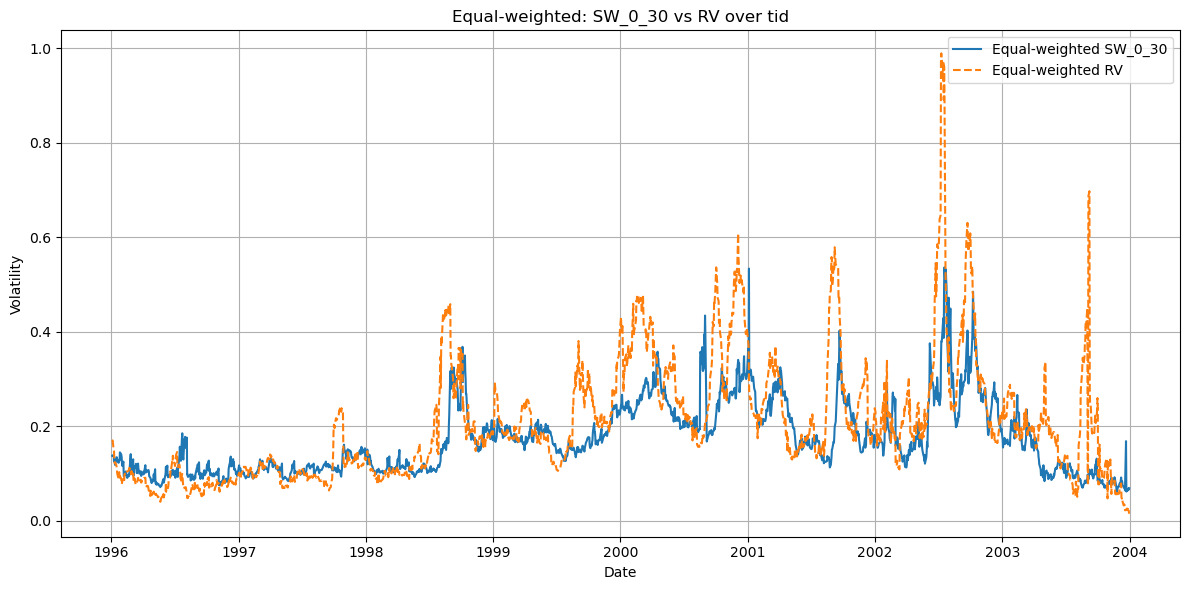

In [237]:
import matplotlib.pyplot as plt

# Plot Equal-weighted
plt.figure(figsize=(12, 6))
plt.plot(summary_df.index, summary_df["SW_0_30_equalweight"], label="Equal-weighted SW_0_30")
plt.plot(summary_df.index, summary_df["RV_equalweight"], label="Equal-weighted RV", linestyle="--")
plt.title("Equal-weighted: SW_0_30 vs RV over tid")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


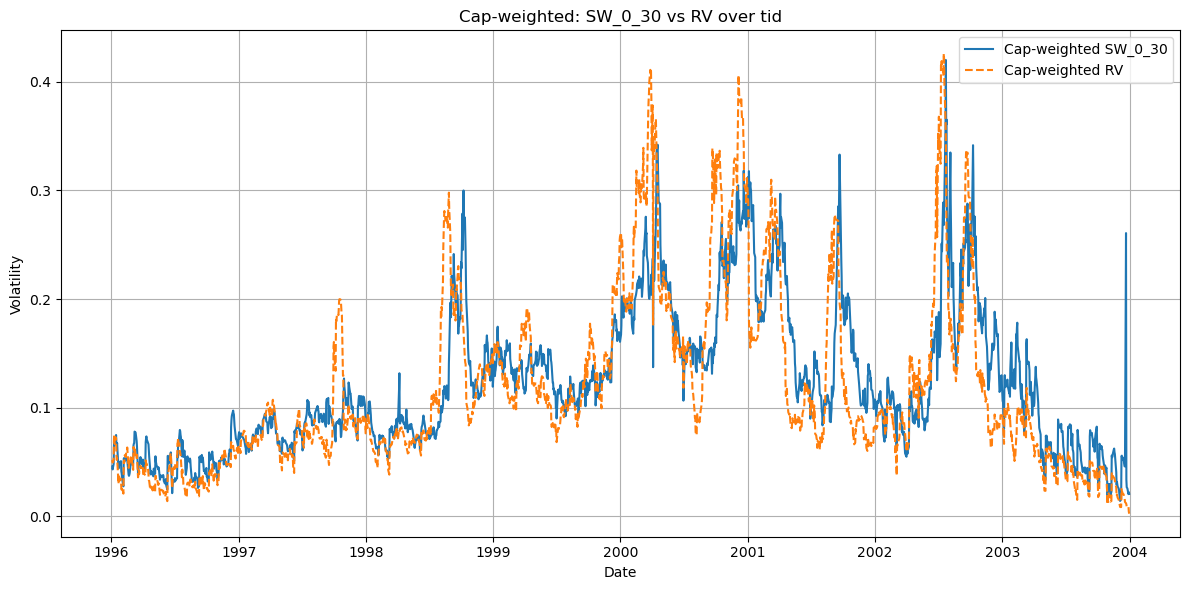

In [238]:
# Plot Cap-weighted
plt.figure(figsize=(12, 6))
plt.plot(summary_df.index, summary_df["SW_0_30_capweight"], label="Cap-weighted SW_0_30")
plt.plot(summary_df.index, summary_df["RV_capweight"], label="Cap-weighted RV", linestyle="--")
plt.title("Cap-weighted: SW_0_30 vs RV over tid")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### vrp average pr ticker

c:\Users\axell\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\axell\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


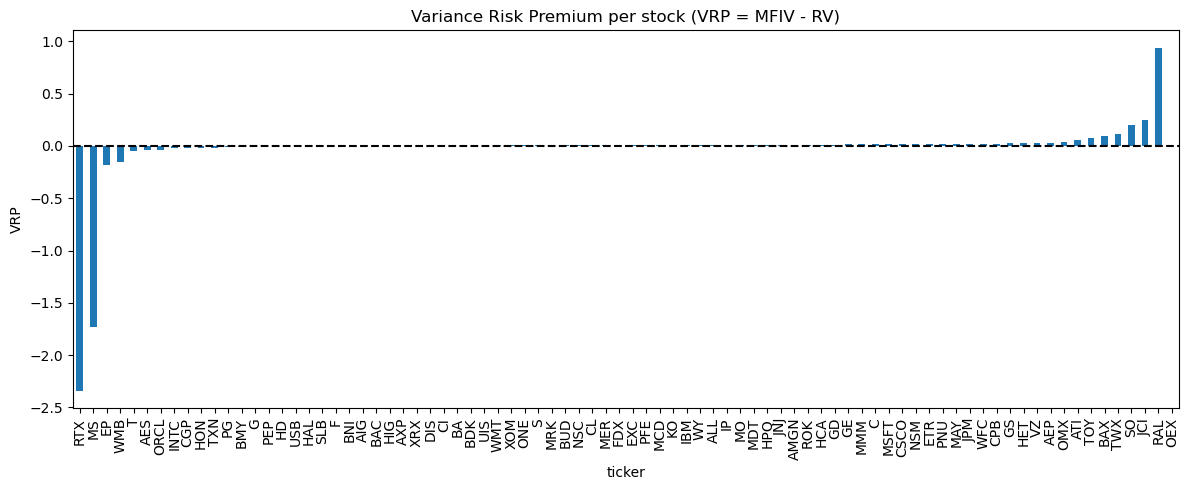

In [142]:
# Lav kopi med relevante kolonner
df_vrp = sum_df[["ticker", "date", "SW_0_30", "RV"]].copy()

# Beregn MFIV, VRP og log-ratio
df_vrp["MFIV"] = df_vrp["SW_0_30"]
df_vrp["VRP"] = df_vrp["MFIV"] - df_vrp["RV"]
df_vrp["log_RV_MFIV"] = np.log(df_vrp["RV"] / df_vrp["MFIV"])

# Gennemsnit pr. ticker
vrp_per_stock = df_vrp.groupby("ticker")[["VRP", "log_RV_MFIV"]].mean().sort_values("VRP")

# (Valgfrit) plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
vrp_per_stock["VRP"].plot(kind="bar")
plt.axhline(0, color="black", linestyle="--")
plt.title("Variance Risk Premium per stock (VRP = MFIV - RV)")
plt.ylabel("VRP")
plt.tight_layout()
plt.show()


### table 1 (data to table 1)

In [127]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

# Antag df_orpy eksisterer og har kolonnerne: 'ticker', 'date', 'SW_0_30', 'RV'
# 1. Beregn VRP
df_vrp = df_orpy.copy()
df_vrp["VRP"] = df_vrp["SW_0_30"] - df_vrp["RV"]

# 2. T-test per ticker med Newey-West standard errors
result_rows = []

for ticker, group in df_vrp.groupby("ticker"):
    group = group.dropna(subset=["VRP"])

    if group.empty or len(group) < 30 or group["VRP"].isna().all():
        continue

    X = add_constant(pd.DataFrame(index=group.index))  
    y = group["VRP"].values

    model = OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 22})  # Newey-West standard errors

    t_stat = model.tvalues.iloc[0]
    p_value = model.pvalues.iloc[0]

    mean_vrp = group["VRP"].mean()

    result_rows.append({
        "ticker": ticker,
        "mean_vrp": mean_vrp,
        "t_stat": t_stat,
        "p_value": p_value,
        "n_obs": len(group)
    })

# 3. Konstruér resultater som DataFrame og sorter
df_vrp_test = pd.DataFrame(result_rows)
df_vrp_test = df_vrp_test.sort_values("p_value").reset_index(drop=True)

# Print resultater
print(df_vrp_test)


   ticker  mean_vrp    t_stat       p_value  n_obs
0     OEX  0.015946  6.016974  1.777076e-09   2013
1     MMM  0.014239  2.927283  3.419371e-03   1859
2      GE  0.014030  2.782373  5.396301e-03   1903
3     LMT  0.021643  2.577821  9.942538e-03   1621
4      GD  0.013434  2.311066  2.082919e-02   1529
5    MSFT  0.018254  2.301221  2.137915e-02   1957
6     JNJ  0.011767  2.160623  3.072446e-02   1746
7     NKE  0.018112  1.802037  7.153955e-02   1950
8      KO  0.009739  1.791551  7.320498e-02   1700
9     MDT  0.010544  1.765097  7.754741e-02   1896
10    BAC  0.010366  1.733882  8.293899e-02   1913
11    FDX  0.008027  1.593861  1.109671e-01   1775
12    MCD  0.009355  1.560947  1.185362e-01   1519
13     MO  0.012245  1.486936  1.370317e-01   1945
14    PFE  0.009223  1.439905  1.498943e-01   1900
15   INTC -0.021750 -1.434489  1.514328e-01   1966
16    CAT  0.008303  1.409931  1.585600e-01   1768
17    IBM  0.009985  1.365284  1.721639e-01   2008
18      T  0.009779  1.340745  

### table 1

In [128]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

# Beregn VRP
df_vrp = df_orpy.copy()
df_vrp["VRP"] = df_vrp["SW_0_30"] - df_vrp["RV"]

# Split: OEX vs øvrige
df_oex = df_vrp[df_vrp["ticker"] == "OEX"].dropna(subset=["SW_0_30", "RV"])
df_ind = df_vrp[df_vrp["ticker"] != "OEX"].dropna(subset=["SW_0_30", "RV"])

# Gennemsnit
mean_rv_oex = df_oex["RV"].mean()
mean_sw_oex = df_oex["SW_0_30"].mean()
mean_rv_ind = df_ind["RV"].mean()
mean_sw_ind = df_ind["SW_0_30"].mean()

# sqrt forskelle
sqrt_diff_oex = np.sqrt(mean_rv_oex) - np.sqrt(mean_sw_oex)
sqrt_diff_ind = np.sqrt(mean_rv_ind) - np.sqrt(mean_sw_ind)

# OLS tests med Newey-West
X_oex = add_constant(np.ones(len(df_oex)))
y_oex = df_oex["VRP"]
model_oex = OLS(y_oex, X_oex).fit(cov_type="HAC", cov_kwds={"maxlags": 22})
p_vrp_eq_0_oex = model_oex.pvalues.iloc[0]

ratios_oex = df_oex["RV"] / df_oex["SW_0_30"]
ratios_oex = ratios_oex.replace([np.inf, 0], np.nan).dropna()
Xr_oex = add_constant(np.ones(len(ratios_oex)))
model_ratio_oex = OLS(ratios_oex - 1, Xr_oex).fit(cov_type="HAC", cov_kwds={"maxlags": 22})
p_ratio_eq_1_oex = model_ratio_oex.pvalues.iloc[0]

X_ind = add_constant(np.ones(len(df_ind)))
y_ind = df_ind["VRP"]
model_ind = OLS(y_ind, X_ind).fit(cov_type="HAC", cov_kwds={"maxlags": 22})
p_vrp_eq_0_ind = model_ind.pvalues.iloc[0]

ratios_ind = df_ind["RV"] / df_ind["SW_0_30"]
ratios_ind = ratios_ind.replace([np.inf, 0], np.nan).dropna()
Xr_ind = add_constant(np.ones(len(ratios_ind)))
model_ratio_ind = OLS(ratios_ind - 1, Xr_ind).fit(cov_type="HAC", cov_kwds={"maxlags": 22})
p_ratio_eq_1_ind = model_ratio_ind.pvalues.iloc[0]

# Samlet tabel
summary_table = pd.DataFrame({
    "Category": [
        "Mean Realized Variance",
        "Mean Implied Variance (SW)",
        "Difference √RV − √SW",
        "p value for H₀: RV - SW = 0",
        "p value for H₀: RV / SW - 1 = 0"
    ],
    "Index Options (OEX)": [
        round(np.sqrt(mean_rv_oex), 6),
        round(np.sqrt(mean_sw_oex), 6),
        round(sqrt_diff_oex, 6),
        round(p_vrp_eq_0_oex, 6),
        round(p_ratio_eq_1_oex, 6)
    ],
    "Individual Options": [
        round(mean_rv_ind, 6),
        round(mean_sw_ind, 6),
        round(sqrt_diff_ind, 6),
        round(p_vrp_eq_0_ind, 6),
        round(p_ratio_eq_1_ind, 6)
    ]
})

# Udskriv tabel
print("\nSummary Table (SW terminologi):\n")
print(summary_table.to_string(index=False, col_space=35))


# Antag df_vrp_test eksisterer fra tidligere (output fra OLS tests per ticker)

# Filtrér kun individuelle aktier (dvs. ekskluder "OEX")
df_vrp_individuals = df_vrp_test[df_vrp_test["ticker"] != "OEX"]

# Antal pr kategori
summary_test_counts = pd.DataFrame({
    "Hypothesis": [
        "H₀: RV - SW = 0 not rejected",
        "H₀: RV - SW ≤ 0 rejected",
        "H₀: RV - SW ≥ 0 rejected"
    ],
    "# Ind. Stocks": [
        (df_vrp_individuals["p_value"] > 0.05).sum(),
        (df_vrp_individuals["t_stat"] > 0).sum(),
        (df_vrp_individuals["t_stat"] < 0).sum()
    ]
})

# Udskriv
print("\nIndividual Tests of Variance Risk Premia:\n")
print(summary_test_counts.to_string(index=False, col_space=40))





Summary Table (SW terminologi):

                           Category                 Index Options (OEX)                  Individual Options
             Mean Realized Variance                            0.208383                            0.152782
         Mean Implied Variance (SW)                            0.243659                            0.156450
               Difference √RV − √SW                           -0.035276                           -0.004664
        p value for H₀: RV - SW = 0                            0.000000                            0.000216
    p value for H₀: RV / SW - 1 = 0                            0.000000                            0.027315

Individual Tests of Variance Risk Premia:

                              Hypothesis                            # Ind. Stocks
            H₀: RV - SW = 0 not rejected                                       39
                H₀: RV - SW ≤ 0 rejected                                       32
                H₀: RV - SW 

# Section 3.B

In [129]:
sum_df['CF_30_SW_day'] = sum_df['CF_30_SW_day_v2']
sum_df["r_30_SW_day"] = sum_df["CF_30_SW_day"] / sum_df["SW_m1_29"].shift(1).rolling(window=21).mean()

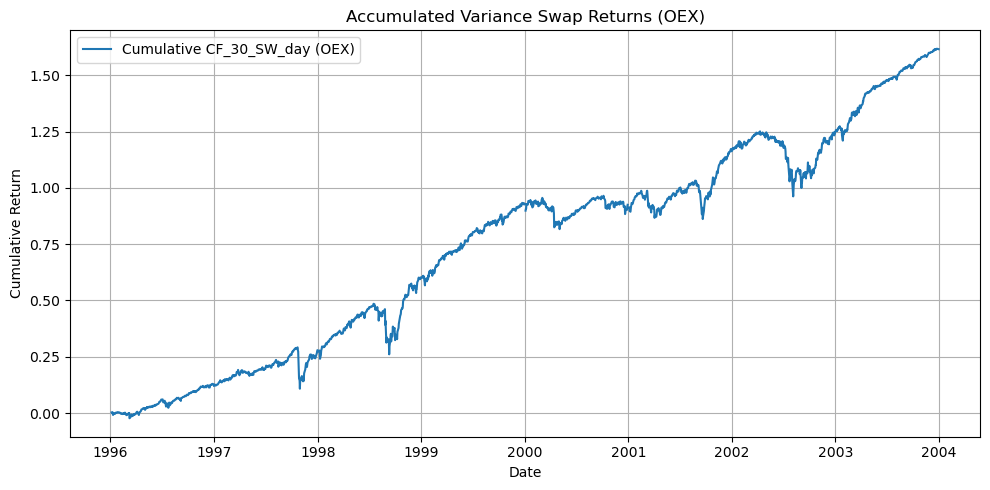

In [130]:
import matplotlib.pyplot as plt

# Filtrér for OEX
oex_df = sum_df[sum_df["ticker"] == "OEX"].copy()

# Sørg for sortering efter dato
oex_df = oex_df.sort_values("date")

# Beregn akkumuleret sum
oex_df["cum_CF_30_SW_day"] = -oex_df["CF_30_SW_day"].cumsum()

# Plot
plt.figure(figsize=(10, 5))
plt.plot(oex_df["date"], oex_df["cum_CF_30_SW_day"], label="Cumulative CF_30_SW_day (OEX)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.title("Accumulated Variance Swap Returns (OEX)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [131]:
# Antag: sum_df har kolonnerne 'ticker', 'date', 'r_30_SW_day'
# Step 1: Fjern OEX og NA'er
vrp_data = sum_df[sum_df["ticker"] != "OEX"].copy()
vrp_data = vrp_data.dropna(subset=["r_30_SW_day"])

# Step 2: Beregn daglig VRP faktor som ligevægtet gennemsnit
vrp_factor = vrp_data.groupby("date")["r_30_SW_day"].mean().reset_index()
vrp_factor.rename(columns={"r_30_SW_day": "VRP_factor_eqw"}, inplace=True)

# Preview
print(vrp_factor.head())


        date  VRP_factor_eqw
0 1996-02-15       -0.130664
1 1996-03-06        0.025567
2 1996-03-07       -0.032031
3 1996-03-08        0.243584
4 1996-03-11       -0.028081


# Section 4.A trading strategy

### create rollnig correlation estimate

In [132]:
import pandas as pd
import numpy as np

sum_df_filtered = sum_df[sum_df['ticker'] != 'OEX'].copy()
sum_df_filtered.loc[:, 'date'] = pd.to_datetime(sum_df_filtered['date'])
pivot_df = sum_df_filtered.pivot(index='date', columns='ticker', values='return')
pivot_df = pivot_df.sort_index()

rolling_avg_corr = []
window = 30

for i in range(window, len(pivot_df)):
    window_returns = pivot_df.iloc[i - window:i]
    corr_matrix = window_returns.corr()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    avg_corr = upper_triangle.stack().mean()
    rolling_avg_corr.append((pivot_df.index[i], avg_corr))

avg_corr_df = pd.DataFrame(rolling_avg_corr, columns=['date', 'avg_correlation'])


# import matplotlib.pyplot as plt

# plt.figure(figsize=(12, 6))
# plt.plot(avg_corr_df['date'], avg_corr_df['avg_correlation'])
# plt.title('30-dages gennemsnitlig korrelation over tid')
# plt.xlabel('Dato')
# plt.ylabel('Gennemsnitlig korrelation')
# plt.grid(True)
# plt.tight_layout()
# plt.show()



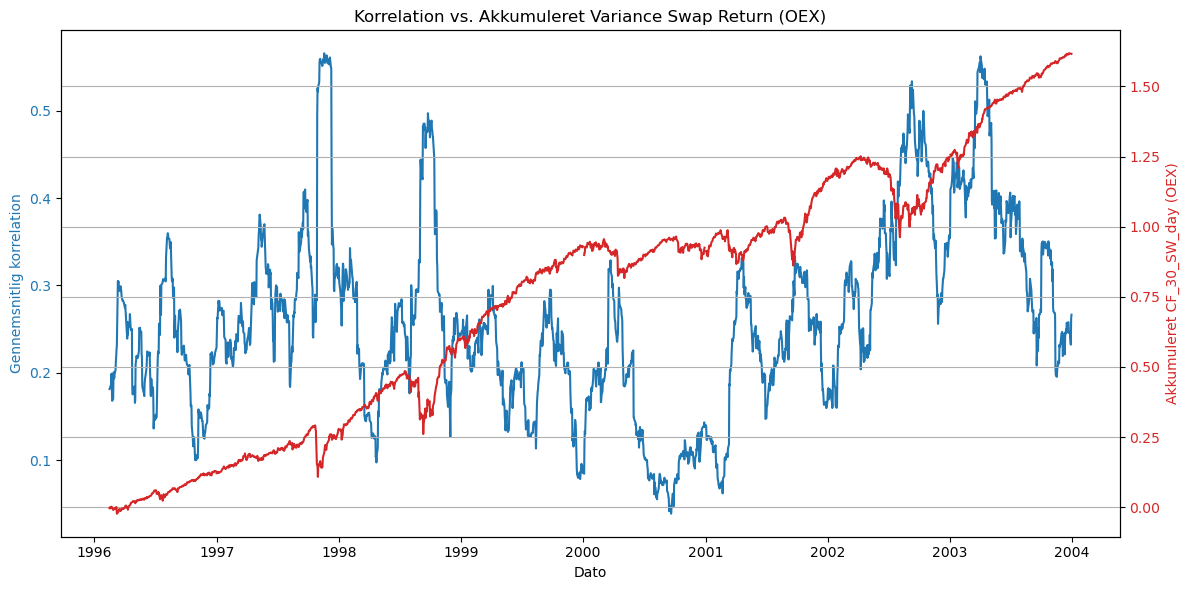

In [133]:
import matplotlib.pyplot as plt

# Filtrér for OEX og forbered data
oex_df = sum_df[sum_df["ticker"] == "OEX"].copy()
oex_df = oex_df.sort_values("date")
oex_df["cum_CF_30_SW_day"] = -oex_df["CF_30_SW_day"].cumsum()

# Merge OEX og korrelationer på dato
merged_df = pd.merge(avg_corr_df, oex_df[["date", "cum_CF_30_SW_day"]], on="date", how="inner")

# Plot med to akser
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel("Dato")
ax1.set_ylabel("Gennemsnitlig korrelation", color=color)
ax1.plot(merged_df["date"], merged_df["avg_correlation"], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel("Akkumuleret CF_30_SW_day (OEX)", color=color)
ax2.plot(merged_df["date"], merged_df["cum_CF_30_SW_day"], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Korrelation vs. Akkumuleret Variance Swap Return (OEX)")
fig.tight_layout()
plt.grid(True)
plt.show()


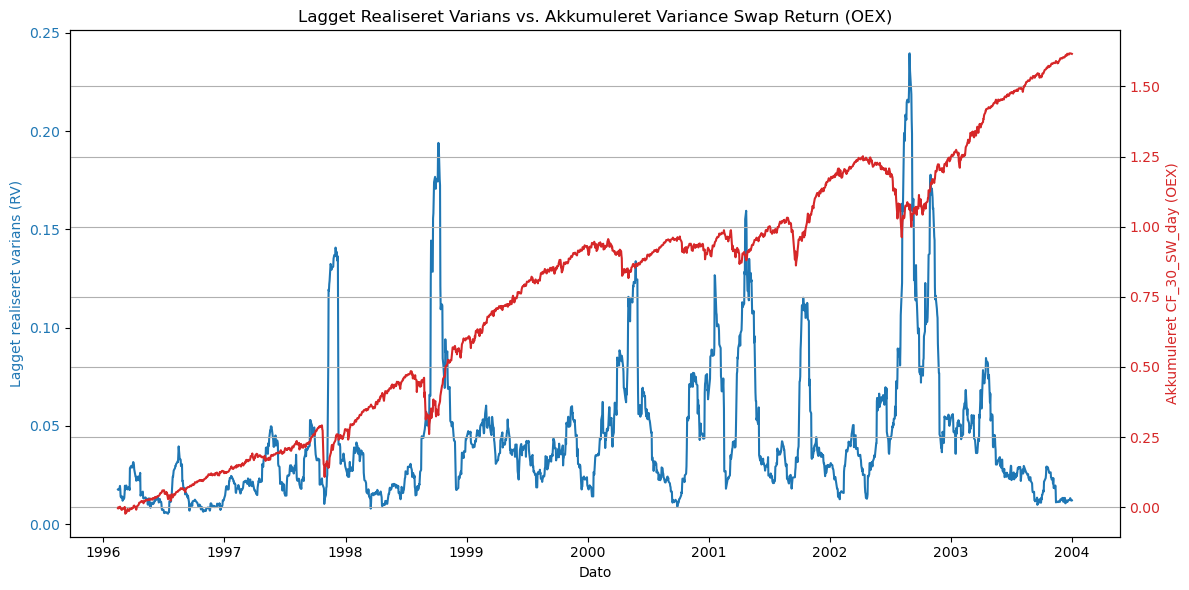

In [134]:
import matplotlib.pyplot as plt

# Filtrér for OEX og sorter
oex_df = sum_df[sum_df["ticker"] == "OEX"].copy()
oex_df = oex_df.sort_values("date")

# Lag realiseret varians 30 dage bagud
oex_df["RV_lagged"] = oex_df["RV"].shift(30)

# Beregn akkumuleret variance swap cashflow
oex_df["cum_CF_30_SW_day"] = -oex_df["CF_30_SW_day"].cumsum()

# Drop NA (som kommer fra shift)
oex_df = oex_df.dropna(subset=["RV_lagged", "cum_CF_30_SW_day"])

# Plot
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel("Dato")
ax1.set_ylabel("Lagget realiseret varians (RV)", color=color)
ax1.plot(oex_df["date"], oex_df["RV_lagged"], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel("Akkumuleret CF_30_SW_day (OEX)", color=color)
ax2.plot(oex_df["date"], oex_df["cum_CF_30_SW_day"], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Lagget Realiseret Varians vs. Akkumuleret Variance Swap Return (OEX)")
plt.grid(True)
fig.tight_layout()
plt.show()


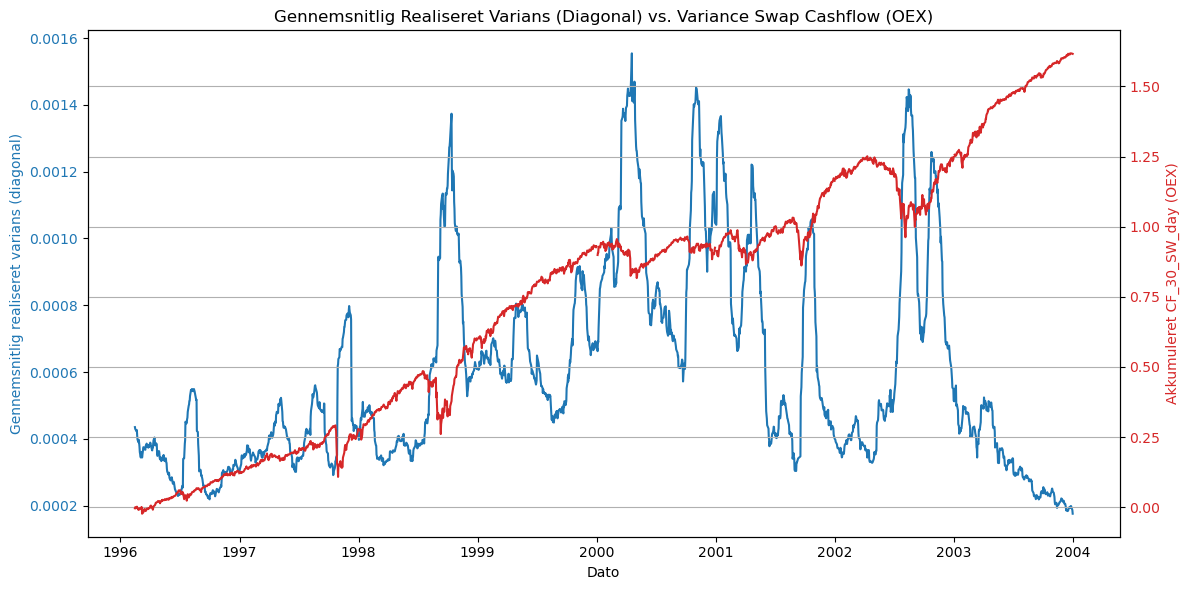

In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Filtrer OEX fra
returns_df = sum_df[sum_df["ticker"] != "OEX"].copy()
returns_df['date'] = pd.to_datetime(returns_df['date'])

# Pivotér til (dato × ticker) matrix
pivot_df = returns_df.pivot(index='date', columns='ticker', values='return')
pivot_df = pivot_df.sort_index()

# Beregn rullende gennemsnitlig diagonal (varians)
window = 30
avg_diag_variance = []

for i in range(window, len(pivot_df)):
    window_returns = pivot_df.iloc[i - window:i]
    cov_matrix = window_returns.cov()
    diag_var = np.diag(cov_matrix)
    avg_var = np.nanmean(diag_var)
    avg_diag_variance.append((pivot_df.index[i], avg_var))

avg_var_df = pd.DataFrame(avg_diag_variance, columns=['date', 'avg_variance'])

# Forbered OEX cashflow
oex_df = sum_df[sum_df["ticker"] == "OEX"].copy()
oex_df = oex_df.sort_values("date")
oex_df["cum_CF_30_SW_day"] = -oex_df["CF_30_SW_day"].cumsum()

# Merge begge tidsserier
merged_df = pd.merge(avg_var_df, oex_df[["date", "cum_CF_30_SW_day"]], on="date", how="inner")

# Plot
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel("Dato")
ax1.set_ylabel("Gennemsnitlig realiseret varians (diagonal)", color=color)
ax1.plot(merged_df["date"], merged_df["avg_variance"], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel("Akkumuleret CF_30_SW_day (OEX)", color=color)
ax2.plot(merged_df["date"], merged_df["cum_CF_30_SW_day"], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Gennemsnitlig Realiseret Varians (Diagonal) vs. Variance Swap Cashflow (OEX)")
plt.grid(True)
fig.tight_layout()
plt.show()


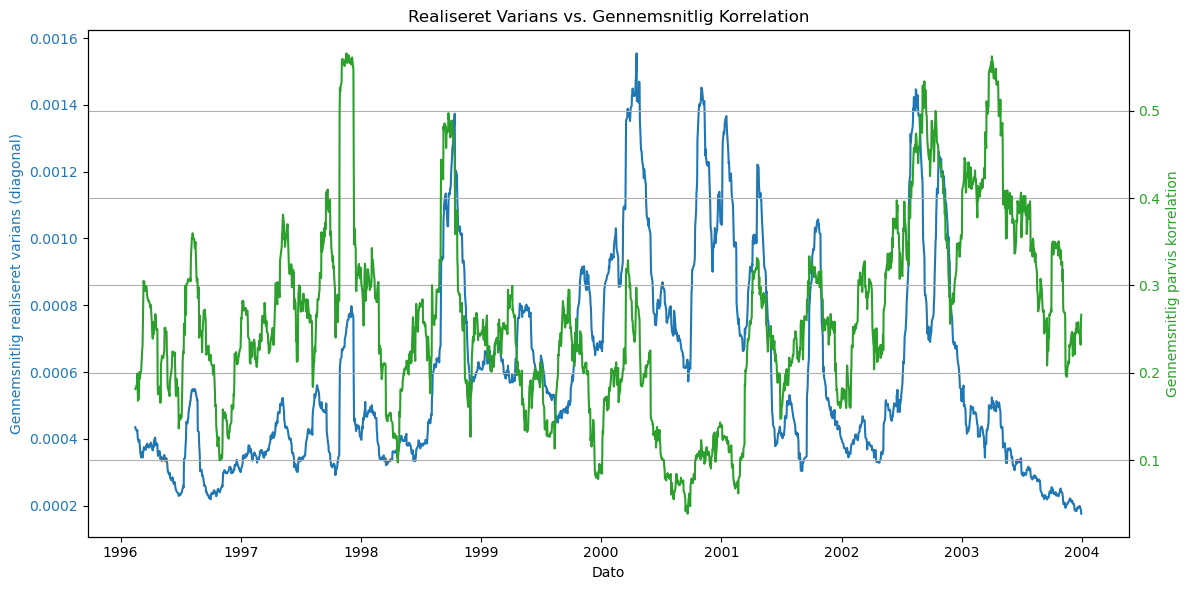

In [138]:
import matplotlib.pyplot as plt

# Merge realiseret varians og korrelation på dato
merged_metrics = pd.merge(avg_var_df, avg_corr_df, on='date', how='inner')

# Plot
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel("Dato")
ax1.set_ylabel("Gennemsnitlig realiseret varians (diagonal)", color=color)
ax1.plot(merged_metrics["date"], merged_metrics["avg_variance"], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel("Gennemsnitlig parvis korrelation", color=color)
ax2.plot(merged_metrics["date"], merged_metrics["avg_correlation"], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Realiseret Varians vs. Gennemsnitlig Korrelation")
plt.grid(True)
fig.tight_layout()
plt.show()


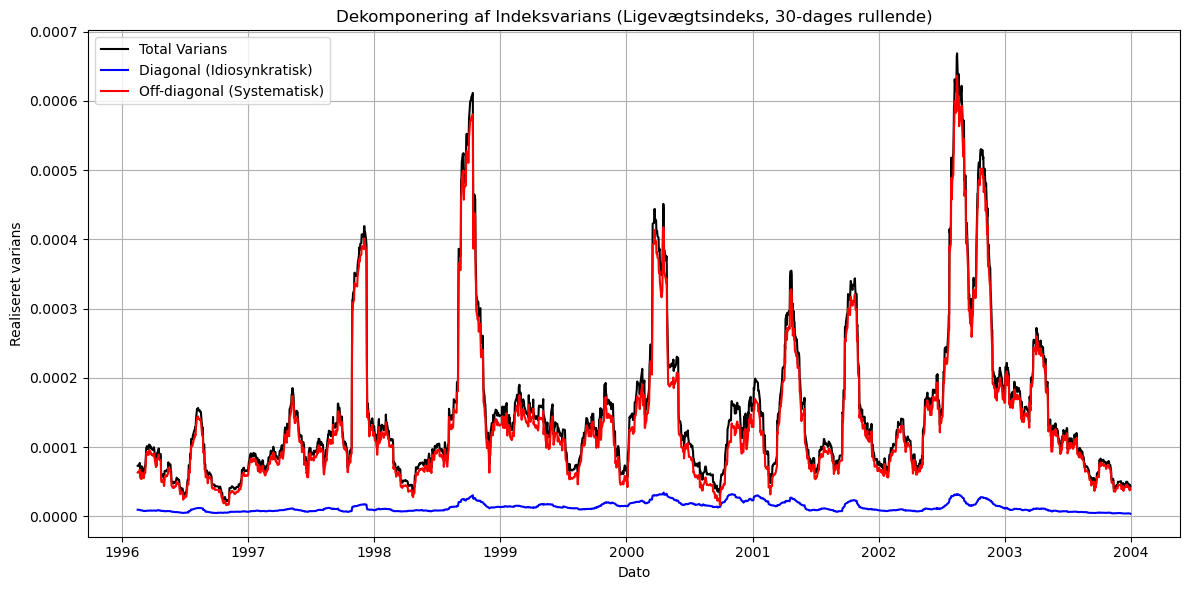

In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Forbered data (ekskluder OEX)
returns_df = sum_df[sum_df["ticker"] != "OEX"].copy()
returns_df['date'] = pd.to_datetime(returns_df['date'])
pivot_df = returns_df.pivot(index='date', columns='ticker', values='return')
pivot_df = pivot_df.sort_index()

# Parametre
window = 30
decomp_data = []

# Loop over rullende vinduer
for i in range(window, len(pivot_df)):
    window_returns = pivot_df.iloc[i - window:i]
    cov_matrix = window_returns.cov()
    
    # Antal aktier i dette vindue (kan variere lidt pga. NaNs)
    tickers_in_window = cov_matrix.columns
    N = len(tickers_in_window)
    if N < 2:
        continue  # skip hvis for få data

    # Ligevægtsvægte
    w = np.ones(N) / N
    w_matrix = np.outer(w, w)

    # Total indeksvarians
    total_variance = np.sum(w_matrix * cov_matrix.values)

    # Diagonalbidrag (idiosynkratisk)
    diag = np.diag(cov_matrix.values)
    diag_variance = np.sum((w ** 2) * diag)

    # Off-diagonalbidrag
    off_diag_variance = total_variance - diag_variance

    # Gem resultat
    decomp_data.append((pivot_df.index[i], total_variance, diag_variance, off_diag_variance))

# Konverter til DataFrame
decomp_df = pd.DataFrame(decomp_data, columns=["date", "total", "diagonal", "off_diagonal"])

# Plot
plt.figure(figsize=(12, 6))
plt.plot(decomp_df["date"], decomp_df["total"], label="Total Varians", color="black")
plt.plot(decomp_df["date"], decomp_df["diagonal"], label="Diagonal (Idiosynkratisk)", color="blue")
plt.plot(decomp_df["date"], decomp_df["off_diagonal"], label="Off-diagonal (Systematisk)", color="red")
plt.title("Dekomponering af Indeksvarians (Ligevægtsindeks, 30-dages rullende)")
plt.xlabel("Dato")
plt.ylabel("Realiseret varians")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


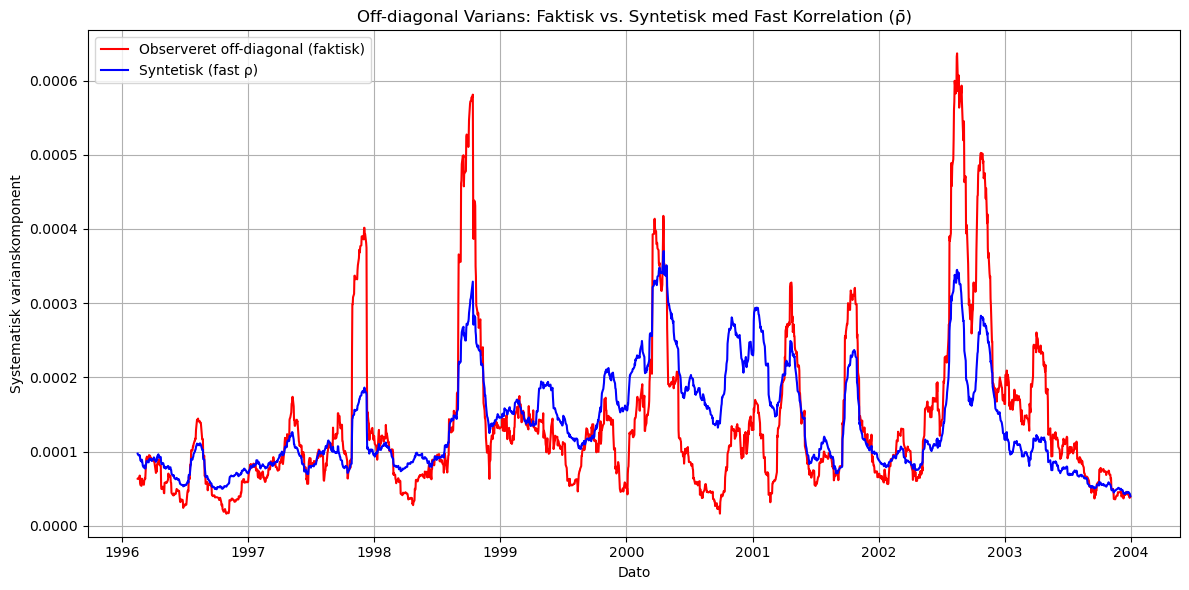

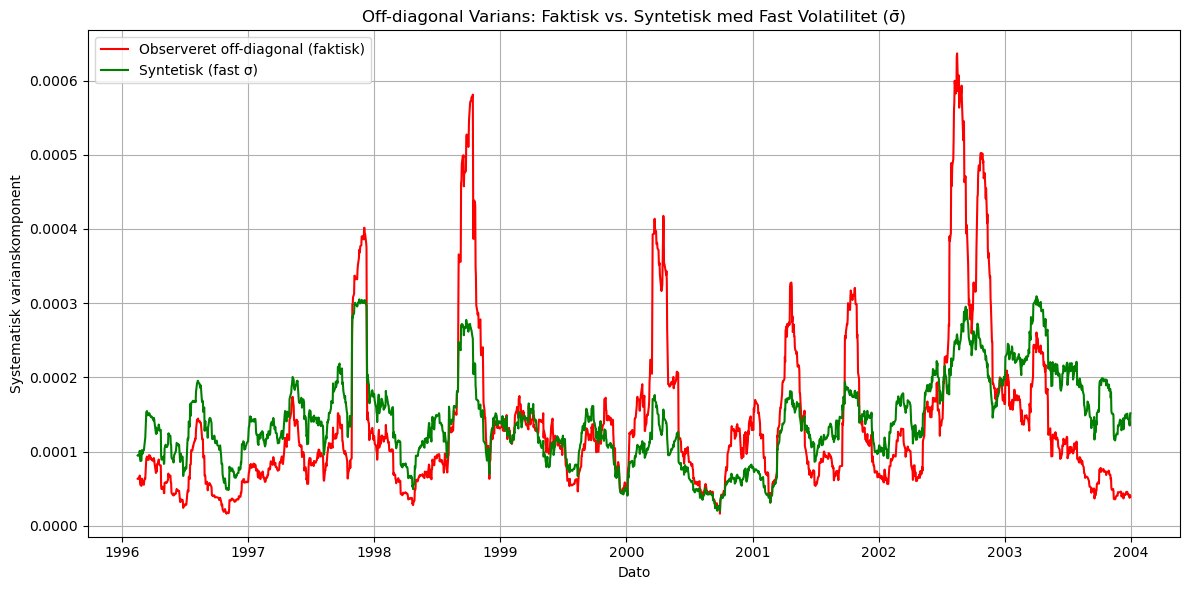

In [149]:
# Vælg om vi vil skalere syntetiske resultater
scale = False  # Sæt til True hvis du vil matche niveauer

# --------- Fast korrelation ---------
avg_rho = avg_corr_df["avg_correlation"].mean()
synthetic_off = []

for i in range(window, len(pivot_df)):
    window_returns = pivot_df.iloc[i - window:i]
    cov_matrix = window_returns.cov()

    tickers = cov_matrix.columns
    N = len(tickers)
    if N < 2:
        continue

    sigmas = np.sqrt(np.diag(cov_matrix.values))
    rho_matrix = np.full((N, N), avg_rho)
    np.fill_diagonal(rho_matrix, 0)
    sigma_outer = np.outer(sigmas, sigmas)
    synthetic_cov_off = rho_matrix * sigma_outer

    w = np.ones(N) / N
    w_matrix = np.outer(w, w)
    off_diag_mask = ~np.eye(N, dtype=bool)
    weighted_synthetic_off = synthetic_cov_off * w_matrix * off_diag_mask

    synthetic_off_value = np.sum(weighted_synthetic_off)
    synthetic_off.append((pivot_df.index[i], synthetic_off_value))

synthetic_off_df = pd.DataFrame(synthetic_off, columns=["date", "synthetic_off"])
compare_df = pd.merge(decomp_df[["date", "off_diagonal"]], synthetic_off_df, on="date", how="inner")

if scale:
    scaling_factor = (compare_df["off_diagonal"] / compare_df["synthetic_off"]).mean()
    compare_df["synthetic_plot"] = compare_df["synthetic_off"] * scaling_factor
else:
    compare_df["synthetic_plot"] = compare_df["synthetic_off"]

plt.figure(figsize=(12, 6))
plt.plot(compare_df["date"], compare_df["off_diagonal"], label="Observeret off-diagonal (faktisk)", color="red")
plt.plot(compare_df["date"], compare_df["synthetic_plot"], label="Syntetisk (fast ρ)", color="blue")
plt.title("Off-diagonal Varians: Faktisk vs. Syntetisk med Fast Korrelation (ρ̄)")
plt.xlabel("Dato")
plt.ylabel("Systematisk varianskomponent")
plt.legend(loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

# --------- Fast sigma ---------
long_cov = pivot_df.cov()
avg_sigmas = pd.Series(np.sqrt(np.diag(long_cov)), index=long_cov.columns)

rho_only_off = []

for i in range(window, len(pivot_df)):
    window_returns = pivot_df.iloc[i - window:i]
    corr_matrix = window_returns.corr()

    tickers = corr_matrix.columns
    N = len(tickers)
    if N < 2:
        continue

    sigmas_window = avg_sigmas.loc[tickers].values
    sigma_outer = np.outer(sigmas_window, sigmas_window)
    rho_matrix = corr_matrix.values.copy()
    np.fill_diagonal(rho_matrix, 0)

    w = np.ones(N) / N
    w_matrix = np.outer(w, w)
    off_diag_mask = ~np.eye(N, dtype=bool)
    synthetic_cov = rho_matrix * sigma_outer
    weighted_synthetic_off = synthetic_cov * w_matrix * off_diag_mask

    total_synthetic_off = np.sum(weighted_synthetic_off)
    rho_only_off.append((pivot_df.index[i], total_synthetic_off))

rho_only_df = pd.DataFrame(rho_only_off, columns=["date", "rho_only_off"])
compare_df_rho = pd.merge(decomp_df[["date", "off_diagonal"]], rho_only_df, on="date", how="inner")

if scale:
    scaling_rho = (compare_df_rho["off_diagonal"] / compare_df_rho["rho_only_off"]).mean()
    compare_df_rho["synthetic_plot"] = compare_df_rho["rho_only_off"] * scaling_rho
else:
    compare_df_rho["synthetic_plot"] = compare_df_rho["rho_only_off"]

plt.figure(figsize=(12, 6))
plt.plot(compare_df_rho["date"], compare_df_rho["off_diagonal"], label="Observeret off-diagonal (faktisk)", color="red")
plt.plot(compare_df_rho["date"], compare_df_rho["synthetic_plot"], label="Syntetisk (fast σ)", color="green")
plt.title("Off-diagonal Varians: Faktisk vs. Syntetisk med Fast Volatilitet (σ̄)")
plt.xlabel("Dato")
plt.ylabel("Systematisk varianskomponent")
plt.legend(loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()


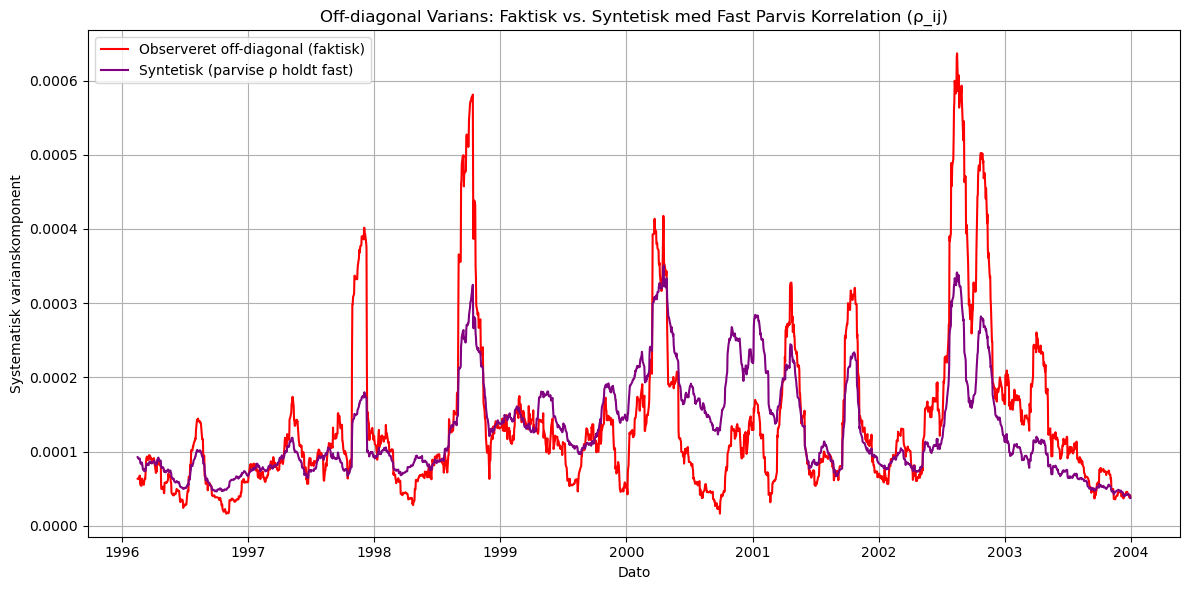

In [150]:
# Vælg om vi vil skalere syntetiske resultater
scale = False  # Sæt til True hvis du vil matche niveauer

# --------- Fast parvis korrelation (hele rho-matrix holdes fast) ---------

# Beregn gennemsnitlig korrelationsmatrix over hele perioden
full_corr = pivot_df.corr()
avg_corr_matrix = full_corr.values.copy()
np.fill_diagonal(avg_corr_matrix, 0)

synthetic_off_pairwise = []

for i in range(window, len(pivot_df)):
    window_returns = pivot_df.iloc[i - window:i]
    tickers = window_returns.columns
    N = len(tickers)
    if N < 2:
        continue

    cov_matrix = window_returns.cov()
    sigmas = np.sqrt(np.diag(cov_matrix.values))

    # Udtræk kun den relevante del af avg_corr_matrix for aktuelle tickers
    idx = [pivot_df.columns.get_loc(t) for t in tickers]
    rho_matrix = avg_corr_matrix[np.ix_(idx, idx)]

    sigma_outer = np.outer(sigmas, sigmas)
    synthetic_cov_off = rho_matrix * sigma_outer

    w = np.ones(N) / N
    w_matrix = np.outer(w, w)
    off_diag_mask = ~np.eye(N, dtype=bool)
    weighted_synthetic_off = synthetic_cov_off * w_matrix * off_diag_mask

    synthetic_value = np.sum(weighted_synthetic_off)
    synthetic_off_pairwise.append((pivot_df.index[i], synthetic_value))

synthetic_pairwise_df = pd.DataFrame(synthetic_off_pairwise, columns=["date", "synthetic_off_pairwise"])
compare_df_pairwise = pd.merge(decomp_df[["date", "off_diagonal"]], synthetic_pairwise_df, on="date", how="inner")

if scale:
    scaling_pairwise = (compare_df_pairwise["off_diagonal"] / compare_df_pairwise["synthetic_off_pairwise"]).mean()
    compare_df_pairwise["synthetic_plot"] = compare_df_pairwise["synthetic_off_pairwise"] * scaling_pairwise
else:
    compare_df_pairwise["synthetic_plot"] = compare_df_pairwise["synthetic_off_pairwise"]

plt.figure(figsize=(12, 6))
plt.plot(compare_df_pairwise["date"], compare_df_pairwise["off_diagonal"], label="Observeret off-diagonal (faktisk)", color="red")
plt.plot(compare_df_pairwise["date"], compare_df_pairwise["synthetic_plot"], label="Syntetisk (parvise ρ holdt fast)", color="purple")
plt.title("Off-diagonal Varians: Faktisk vs. Syntetisk med Fast Parvis Korrelation (ρ_ij)")
plt.xlabel("Dato")
plt.ylabel("Systematisk varianskomponent")
plt.legend(loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()


### trading strategy implement

In [ ]:
[ '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

# 0203524D = NSM
# NRTLQ = NT
# MTLQQ = GM
# LEHMQ = LEH
# NAN = NQN
# RSHCQ = RSH
# 987200Q = MAY
# 748957Q = PNU
# 653707Q = T
# 605555Q = S
# 3621240Q = ONE
# 3605818Q = HCA
# 3346Q = UBAN
# 2968900Q = IHRT
# 2258717D = EMC
# GBLXQ = GBLX
# ENRNQ = ENE
# EKDKQ = KODK
# DALRQ = DAL
# RTN/B = RTNB
# 1996074D = EP
# 3393199Q = BUD
# 1683997D = DELL
# 0848680D = FYBR
# 1255173D = WB
# 2071296D = NYX
# 1856613D = MON
# BRK/B = BRK
# 9903115D = CLB
# 1028411Q = G
# 1697067D = DOW
# 1715651D = DD
